# Miller age

In [1]:
ood_seed = 10

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Lung ciliated cells', '18.0'), 494)


Removed datapoint: 494

train         5507
validation    1404
ood            494
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 101243.33it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1039417.06it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 224.99it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<18:37,  2.80s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<18:37,  2.80s/it, v_num=1, recon=1.18e+3, r2_mean=0.053, adv_loss=3.47, acc_pert=0.307, acc_integration_donor=0.132]

Epoch 2/400:   0%|          | 1/400 [00:02<18:37,  2.80s/it, v_num=1, recon=1.18e+3, r2_mean=0.053, adv_loss=3.47, acc_pert=0.307, acc_integration_donor=0.132]

Epoch 2/400:   0%|          | 2/400 [00:05<17:02,  2.57s/it, v_num=1, recon=1.18e+3, r2_mean=0.053, adv_loss=3.47, acc_pert=0.307, acc_integration_donor=0.132]

Epoch 2/400:   0%|          | 2/400 [00:05<17:02,  2.57s/it, v_num=1, recon=995, r2_mean=0.27, adv_loss=3.03, acc_pert=0.472, acc_integration_donor=0.318]     

Epoch 3/400:   0%|          | 2/400 [00:05<17:02,  2.57s/it, v_num=1, recon=995, r2_mean=0.27, adv_loss=3.03, acc_pert=0.472, acc_integration_donor=0.318]

Epoch 3/400:   1%|          | 3/400 [00:07<16:43,  2.53s/it, v_num=1, recon=995, r2_mean=0.27, adv_loss=3.03, acc_pert=0.472, acc_integration_donor=0.318]

Epoch 3/400:   1%|          | 3/400 [00:07<16:43,  2.53s/it, v_num=1, recon=923, r2_mean=0.368, adv_loss=2.76, acc_pert=0.495, acc_integration_donor=0.448]

Epoch 4/400:   1%|          | 3/400 [00:07<16:43,  2.53s/it, v_num=1, recon=923, r2_mean=0.368, adv_loss=2.76, acc_pert=0.495, acc_integration_donor=0.448]

Epoch 4/400:   1%|          | 4/400 [00:10<16:32,  2.51s/it, v_num=1, recon=923, r2_mean=0.368, adv_loss=2.76, acc_pert=0.495, acc_integration_donor=0.448]

Epoch 4/400:   1%|          | 4/400 [00:10<16:32,  2.51s/it, v_num=1, recon=886, r2_mean=0.418, adv_loss=2.61, acc_pert=0.487, acc_integration_donor=0.51] 

Epoch 5/400:   1%|          | 4/400 [00:10<16:32,  2.51s/it, v_num=1, recon=886, r2_mean=0.418, adv_loss=2.61, acc_pert=0.487, acc_integration_donor=0.51]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:22,  2.49s/it, v_num=1, recon=886, r2_mean=0.418, adv_loss=2.61, acc_pert=0.487, acc_integration_donor=0.51]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:22,  2.49s/it, v_num=1, recon=863, r2_mean=0.44, adv_loss=2.52, acc_pert=0.475, acc_integration_donor=0.526]

Epoch 6/400:   1%|▏         | 5/400 [00:12<16:22,  2.49s/it, v_num=1, recon=863, r2_mean=0.44, adv_loss=2.52, acc_pert=0.475, acc_integration_donor=0.526]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=863, r2_mean=0.44, adv_loss=2.52, acc_pert=0.475, acc_integration_donor=0.526]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=862, r2_mean=0.444, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.529]

Epoch 7/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=862, r2_mean=0.444, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.529]

Epoch 7/400:   2%|▏         | 7/400 [00:17<16:53,  2.58s/it, v_num=1, recon=862, r2_mean=0.444, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.529]

Epoch 7/400:   2%|▏         | 7/400 [00:17<16:53,  2.58s/it, v_num=1, recon=857, r2_mean=0.449, adv_loss=2.39, acc_pert=0.476, acc_integration_donor=0.54] 

Epoch 8/400:   2%|▏         | 7/400 [00:17<16:53,  2.58s/it, v_num=1, recon=857, r2_mean=0.449, adv_loss=2.39, acc_pert=0.476, acc_integration_donor=0.54]

Epoch 8/400:   2%|▏         | 8/400 [00:22<21:07,  3.23s/it, v_num=1, recon=857, r2_mean=0.449, adv_loss=2.39, acc_pert=0.476, acc_integration_donor=0.54]

Epoch 8/400:   2%|▏         | 8/400 [00:22<21:07,  3.23s/it, v_num=1, recon=866, r2_mean=0.459, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.547]

Epoch 9/400:   2%|▏         | 8/400 [00:22<21:07,  3.23s/it, v_num=1, recon=866, r2_mean=0.459, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.547]

Epoch 9/400:   2%|▏         | 9/400 [00:25<20:56,  3.21s/it, v_num=1, recon=866, r2_mean=0.459, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.547]

Epoch 9/400:   2%|▏         | 9/400 [00:25<20:56,  3.21s/it, v_num=1, recon=843, r2_mean=0.461, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.559]

Epoch 10/400:   2%|▏         | 9/400 [00:25<20:56,  3.21s/it, v_num=1, recon=843, r2_mean=0.461, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.559]


disnt_basal = 0.5659660110736002

disnt_after = 1.0292048417788748

val_r2_mean = 0.5084937790578062

val_r2_var = 0.1860501908443191


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:35<33:54,  5.22s/it, v_num=1, recon=843, r2_mean=0.461, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.559]

Epoch 10/400:   2%|▎         | 10/400 [00:35<33:54,  5.22s/it, v_num=1, recon=825, r2_mean=0.467, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.551, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:35<33:54,  5.22s/it, v_num=1, recon=825, r2_mean=0.467, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.551, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:38<29:24,  4.54s/it, v_num=1, recon=825, r2_mean=0.467, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.551, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:38<29:24,  4.54s/it, v_num=1, recon=826, r2_mean=0.474, adv_loss=2.27, acc_pert=0.501, acc_integration_donor=0.559, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:38<29:24,  4.54s/it, v_num=1, recon=826, r2_mean=0.474, adv_loss=2.27, acc_pert=0.501, acc_integration_donor=0.559, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:41<25:43,  3.98s/it, v_num=1, recon=826, r2_mean=0.474, adv_loss=2.27, acc_pert=0.501, acc_integration_donor=0.559, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:41<25:43,  3.98s/it, v_num=1, recon=818, r2_mean=0.471, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.549, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:41<25:43,  3.98s/it, v_num=1, recon=818, r2_mean=0.471, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.549, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:47,  3.53s/it, v_num=1, recon=818, r2_mean=0.471, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.549, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:47,  3.53s/it, v_num=1, recon=810, r2_mean=0.481, adv_loss=2.31, acc_pert=0.488, acc_integration_donor=0.543, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:43<22:47,  3.53s/it, v_num=1, recon=810, r2_mean=0.481, adv_loss=2.31, acc_pert=0.488, acc_integration_donor=0.543, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<20:41,  3.22s/it, v_num=1, recon=810, r2_mean=0.481, adv_loss=2.31, acc_pert=0.488, acc_integration_donor=0.543, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<20:41,  3.22s/it, v_num=1, recon=805, r2_mean=0.483, adv_loss=2.32, acc_pert=0.49, acc_integration_donor=0.541, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [00:46<20:41,  3.22s/it, v_num=1, recon=805, r2_mean=0.483, adv_loss=2.32, acc_pert=0.49, acc_integration_donor=0.541, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<19:06,  2.98s/it, v_num=1, recon=805, r2_mean=0.483, adv_loss=2.32, acc_pert=0.49, acc_integration_donor=0.541, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<19:06,  2.98s/it, v_num=1, recon=848, r2_mean=0.488, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:48<19:06,  2.98s/it, v_num=1, recon=848, r2_mean=0.488, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<17:56,  2.80s/it, v_num=1, recon=848, r2_mean=0.488, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<17:56,  2.80s/it, v_num=1, recon=802, r2_mean=0.495, adv_loss=2.37, acc_pert=0.472, acc_integration_donor=0.535, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:50<17:56,  2.80s/it, v_num=1, recon=802, r2_mean=0.495, adv_loss=2.37, acc_pert=0.472, acc_integration_donor=0.535, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:53<17:12,  2.70s/it, v_num=1, recon=802, r2_mean=0.495, adv_loss=2.37, acc_pert=0.472, acc_integration_donor=0.535, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:53<17:12,  2.70s/it, v_num=1, recon=800, r2_mean=0.497, adv_loss=2.38, acc_pert=0.458, acc_integration_donor=0.533, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:53<17:12,  2.70s/it, v_num=1, recon=800, r2_mean=0.497, adv_loss=2.38, acc_pert=0.458, acc_integration_donor=0.533, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<16:35,  2.61s/it, v_num=1, recon=800, r2_mean=0.497, adv_loss=2.38, acc_pert=0.458, acc_integration_donor=0.533, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<16:35,  2.61s/it, v_num=1, recon=809, r2_mean=0.5, adv_loss=2.43, acc_pert=0.454, acc_integration_donor=0.537, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]  

Epoch 19/400:   4%|▍         | 18/400 [00:55<16:35,  2.61s/it, v_num=1, recon=809, r2_mean=0.5, adv_loss=2.43, acc_pert=0.454, acc_integration_donor=0.537, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:58<16:10,  2.55s/it, v_num=1, recon=809, r2_mean=0.5, adv_loss=2.43, acc_pert=0.454, acc_integration_donor=0.537, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:58<16:10,  2.55s/it, v_num=1, recon=830, r2_mean=0.507, adv_loss=2.43, acc_pert=0.439, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:58<16:10,  2.55s/it, v_num=1, recon=830, r2_mean=0.507, adv_loss=2.43, acc_pert=0.439, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.5179744044955309

disnt_after = 1.0167470433144927

val_r2_mean = 0.5201399339870973

val_r2_var = 0.30290883644060657


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:10<35:34,  5.62s/it, v_num=1, recon=830, r2_mean=0.507, adv_loss=2.43, acc_pert=0.439, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.566, disnt_after=1.03, val_r2_mean=0.508, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:10<35:34,  5.62s/it, v_num=1, recon=793, r2_mean=0.502, adv_loss=2.45, acc_pert=0.436, acc_integration_donor=0.535, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:10<35:34,  5.62s/it, v_num=1, recon=793, r2_mean=0.502, adv_loss=2.45, acc_pert=0.436, acc_integration_donor=0.535, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<29:32,  4.68s/it, v_num=1, recon=793, r2_mean=0.502, adv_loss=2.45, acc_pert=0.436, acc_integration_donor=0.535, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<29:32,  4.68s/it, v_num=1, recon=791, r2_mean=0.507, adv_loss=2.46, acc_pert=0.435, acc_integration_donor=0.524, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:13<29:32,  4.68s/it, v_num=1, recon=791, r2_mean=0.507, adv_loss=2.46, acc_pert=0.435, acc_integration_donor=0.524, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:15<25:27,  4.04s/it, v_num=1, recon=791, r2_mean=0.507, adv_loss=2.46, acc_pert=0.435, acc_integration_donor=0.524, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:15<25:27,  4.04s/it, v_num=1, recon=802, r2_mean=0.506, adv_loss=2.42, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:15<25:27,  4.04s/it, v_num=1, recon=802, r2_mean=0.506, adv_loss=2.42, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<22:40,  3.61s/it, v_num=1, recon=802, r2_mean=0.506, adv_loss=2.42, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<22:40,  3.61s/it, v_num=1, recon=802, r2_mean=0.511, adv_loss=2.43, acc_pert=0.457, acc_integration_donor=0.527, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:18<22:40,  3.61s/it, v_num=1, recon=802, r2_mean=0.511, adv_loss=2.43, acc_pert=0.457, acc_integration_donor=0.527, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<20:31,  3.28s/it, v_num=1, recon=802, r2_mean=0.511, adv_loss=2.43, acc_pert=0.457, acc_integration_donor=0.527, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<20:31,  3.28s/it, v_num=1, recon=788, r2_mean=0.512, adv_loss=2.39, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:21<20:31,  3.28s/it, v_num=1, recon=788, r2_mean=0.512, adv_loss=2.39, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<19:09,  3.07s/it, v_num=1, recon=788, r2_mean=0.512, adv_loss=2.39, acc_pert=0.461, acc_integration_donor=0.528, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<19:09,  3.07s/it, v_num=1, recon=792, r2_mean=0.518, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:23<19:09,  3.07s/it, v_num=1, recon=792, r2_mean=0.518, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<18:12,  2.92s/it, v_num=1, recon=792, r2_mean=0.518, adv_loss=2.46, acc_pert=0.447, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<18:12,  2.92s/it, v_num=1, recon=798, r2_mean=0.524, adv_loss=2.46, acc_pert=0.432, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:26<18:12,  2.92s/it, v_num=1, recon=798, r2_mean=0.524, adv_loss=2.46, acc_pert=0.432, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:28<17:39,  2.84s/it, v_num=1, recon=798, r2_mean=0.524, adv_loss=2.46, acc_pert=0.432, acc_integration_donor=0.518, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:28<17:39,  2.84s/it, v_num=1, recon=787, r2_mean=0.519, adv_loss=2.49, acc_pert=0.406, acc_integration_donor=0.516, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:28<17:39,  2.84s/it, v_num=1, recon=787, r2_mean=0.519, adv_loss=2.49, acc_pert=0.406, acc_integration_donor=0.516, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<17:06,  2.76s/it, v_num=1, recon=787, r2_mean=0.519, adv_loss=2.49, acc_pert=0.406, acc_integration_donor=0.516, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<17:06,  2.76s/it, v_num=1, recon=787, r2_mean=0.521, adv_loss=2.52, acc_pert=0.388, acc_integration_donor=0.517, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:31<17:06,  2.76s/it, v_num=1, recon=787, r2_mean=0.521, adv_loss=2.52, acc_pert=0.388, acc_integration_donor=0.517, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:34<17:16,  2.79s/it, v_num=1, recon=787, r2_mean=0.521, adv_loss=2.52, acc_pert=0.388, acc_integration_donor=0.517, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:34<17:16,  2.79s/it, v_num=1, recon=791, r2_mean=0.523, adv_loss=2.59, acc_pert=0.366, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:34<17:16,  2.79s/it, v_num=1, recon=791, r2_mean=0.523, adv_loss=2.59, acc_pert=0.366, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]


disnt_basal = 0.4744122283034995

disnt_after = 0.9751544704043821

val_r2_mean = 0.5127456804568117

val_r2_var = 0.3422692052342675


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:52<45:56,  7.45s/it, v_num=1, recon=791, r2_mean=0.523, adv_loss=2.59, acc_pert=0.366, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.518, disnt_after=1.02, val_r2_mean=0.52, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:52<45:56,  7.45s/it, v_num=1, recon=783, r2_mean=0.523, adv_loss=2.56, acc_pert=0.369, acc_integration_donor=0.516, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:52<45:56,  7.45s/it, v_num=1, recon=783, r2_mean=0.523, adv_loss=2.56, acc_pert=0.369, acc_integration_donor=0.516, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:55<36:46,  5.98s/it, v_num=1, recon=783, r2_mean=0.523, adv_loss=2.56, acc_pert=0.369, acc_integration_donor=0.516, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:55<36:46,  5.98s/it, v_num=1, recon=790, r2_mean=0.522, adv_loss=2.54, acc_pert=0.373, acc_integration_donor=0.518, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:55<36:46,  5.98s/it, v_num=1, recon=790, r2_mean=0.522, adv_loss=2.54, acc_pert=0.373, acc_integration_donor=0.518, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:57<30:12,  4.92s/it, v_num=1, recon=790, r2_mean=0.522, adv_loss=2.54, acc_pert=0.373, acc_integration_donor=0.518, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:57<30:12,  4.92s/it, v_num=1, recon=784, r2_mean=0.526, adv_loss=2.57, acc_pert=0.36, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:57<30:12,  4.92s/it, v_num=1, recon=784, r2_mean=0.526, adv_loss=2.57, acc_pert=0.36, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:00<25:36,  4.19s/it, v_num=1, recon=784, r2_mean=0.526, adv_loss=2.57, acc_pert=0.36, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:00<25:36,  4.19s/it, v_num=1, recon=794, r2_mean=0.529, adv_loss=2.6, acc_pert=0.35, acc_integration_donor=0.502, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [02:00<25:36,  4.19s/it, v_num=1, recon=794, r2_mean=0.529, adv_loss=2.6, acc_pert=0.35, acc_integration_donor=0.502, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:02<22:55,  3.76s/it, v_num=1, recon=794, r2_mean=0.529, adv_loss=2.6, acc_pert=0.35, acc_integration_donor=0.502, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:02<22:55,  3.76s/it, v_num=1, recon=780, r2_mean=0.529, adv_loss=2.58, acc_pert=0.358, acc_integration_donor=0.509, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:02<22:55,  3.76s/it, v_num=1, recon=780, r2_mean=0.529, adv_loss=2.58, acc_pert=0.358, acc_integration_donor=0.509, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:06<22:04,  3.63s/it, v_num=1, recon=780, r2_mean=0.529, adv_loss=2.58, acc_pert=0.358, acc_integration_donor=0.509, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:06<22:04,  3.63s/it, v_num=1, recon=800, r2_mean=0.532, adv_loss=2.6, acc_pert=0.364, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:06<22:04,  3.63s/it, v_num=1, recon=800, r2_mean=0.532, adv_loss=2.6, acc_pert=0.364, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:08<19:57,  3.29s/it, v_num=1, recon=800, r2_mean=0.532, adv_loss=2.6, acc_pert=0.364, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:08<19:57,  3.29s/it, v_num=1, recon=777, r2_mean=0.53, adv_loss=2.61, acc_pert=0.367, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:08<19:57,  3.29s/it, v_num=1, recon=777, r2_mean=0.53, adv_loss=2.61, acc_pert=0.367, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:11<18:23,  3.04s/it, v_num=1, recon=777, r2_mean=0.53, adv_loss=2.61, acc_pert=0.367, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:11<18:23,  3.04s/it, v_num=1, recon=781, r2_mean=0.534, adv_loss=2.64, acc_pert=0.358, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:11<18:23,  3.04s/it, v_num=1, recon=781, r2_mean=0.534, adv_loss=2.64, acc_pert=0.358, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:13<17:23,  2.88s/it, v_num=1, recon=781, r2_mean=0.534, adv_loss=2.64, acc_pert=0.358, acc_integration_donor=0.503, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:13<17:23,  2.88s/it, v_num=1, recon=774, r2_mean=0.535, adv_loss=2.69, acc_pert=0.358, acc_integration_donor=0.491, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:13<17:23,  2.88s/it, v_num=1, recon=774, r2_mean=0.535, adv_loss=2.69, acc_pert=0.358, acc_integration_donor=0.491, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:16<16:35,  2.76s/it, v_num=1, recon=774, r2_mean=0.535, adv_loss=2.69, acc_pert=0.358, acc_integration_donor=0.491, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:16<16:35,  2.76s/it, v_num=1, recon=769, r2_mean=0.538, adv_loss=2.7, acc_pert=0.35, acc_integration_donor=0.493, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]  

Epoch 40/400:  10%|▉         | 39/400 [02:16<16:35,  2.76s/it, v_num=1, recon=769, r2_mean=0.538, adv_loss=2.7, acc_pert=0.35, acc_integration_donor=0.493, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]


disnt_basal = 0.457181280521182

disnt_after = 1.01248957673247

val_r2_mean = 0.5091160366481001

val_r2_var = 0.35999119552699005


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:29<35:22,  5.90s/it, v_num=1, recon=769, r2_mean=0.538, adv_loss=2.7, acc_pert=0.35, acc_integration_donor=0.493, val_recon=794, disnt_basal=0.474, disnt_after=0.975, val_r2_mean=0.513, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:29<35:22,  5.90s/it, v_num=1, recon=780, r2_mean=0.533, adv_loss=2.65, acc_pert=0.366, acc_integration_donor=0.511, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:29<35:22,  5.90s/it, v_num=1, recon=780, r2_mean=0.533, adv_loss=2.65, acc_pert=0.366, acc_integration_donor=0.511, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:32<30:31,  5.10s/it, v_num=1, recon=780, r2_mean=0.533, adv_loss=2.65, acc_pert=0.366, acc_integration_donor=0.511, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:32<30:31,  5.10s/it, v_num=1, recon=772, r2_mean=0.538, adv_loss=2.66, acc_pert=0.362, acc_integration_donor=0.482, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:32<30:31,  5.10s/it, v_num=1, recon=772, r2_mean=0.538, adv_loss=2.66, acc_pert=0.362, acc_integration_donor=0.482, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:35<25:56,  4.35s/it, v_num=1, recon=772, r2_mean=0.538, adv_loss=2.66, acc_pert=0.362, acc_integration_donor=0.482, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:35<25:56,  4.35s/it, v_num=1, recon=779, r2_mean=0.54, adv_loss=2.66, acc_pert=0.36, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]  

Epoch 43/400:  10%|█         | 42/400 [02:35<25:56,  4.35s/it, v_num=1, recon=779, r2_mean=0.54, adv_loss=2.66, acc_pert=0.36, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<22:34,  3.79s/it, v_num=1, recon=779, r2_mean=0.54, adv_loss=2.66, acc_pert=0.36, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<22:34,  3.79s/it, v_num=1, recon=771, r2_mean=0.539, adv_loss=2.68, acc_pert=0.348, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:37<22:34,  3.79s/it, v_num=1, recon=771, r2_mean=0.539, adv_loss=2.68, acc_pert=0.348, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:40<20:19,  3.43s/it, v_num=1, recon=771, r2_mean=0.539, adv_loss=2.68, acc_pert=0.348, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:40<20:19,  3.43s/it, v_num=1, recon=771, r2_mean=0.543, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:40<20:19,  3.43s/it, v_num=1, recon=771, r2_mean=0.543, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<18:38,  3.15s/it, v_num=1, recon=771, r2_mean=0.543, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.484, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<18:38,  3.15s/it, v_num=1, recon=769, r2_mean=0.544, adv_loss=2.7, acc_pert=0.346, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [02:42<18:38,  3.15s/it, v_num=1, recon=769, r2_mean=0.544, adv_loss=2.7, acc_pert=0.346, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:45<17:28,  2.96s/it, v_num=1, recon=769, r2_mean=0.544, adv_loss=2.7, acc_pert=0.346, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:45<17:28,  2.96s/it, v_num=1, recon=766, r2_mean=0.54, adv_loss=2.72, acc_pert=0.337, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:45<17:28,  2.96s/it, v_num=1, recon=766, r2_mean=0.54, adv_loss=2.72, acc_pert=0.337, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<16:33,  2.81s/it, v_num=1, recon=766, r2_mean=0.54, adv_loss=2.72, acc_pert=0.337, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<16:33,  2.81s/it, v_num=1, recon=778, r2_mean=0.542, adv_loss=2.71, acc_pert=0.349, acc_integration_donor=0.489, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:47<16:33,  2.81s/it, v_num=1, recon=778, r2_mean=0.542, adv_loss=2.71, acc_pert=0.349, acc_integration_donor=0.489, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:50<16:04,  2.74s/it, v_num=1, recon=778, r2_mean=0.542, adv_loss=2.71, acc_pert=0.349, acc_integration_donor=0.489, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:50<16:04,  2.74s/it, v_num=1, recon=812, r2_mean=0.542, adv_loss=2.75, acc_pert=0.352, acc_integration_donor=0.478, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:50<16:04,  2.74s/it, v_num=1, recon=812, r2_mean=0.542, adv_loss=2.75, acc_pert=0.352, acc_integration_donor=0.478, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<15:33,  2.66s/it, v_num=1, recon=812, r2_mean=0.542, adv_loss=2.75, acc_pert=0.352, acc_integration_donor=0.478, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<15:33,  2.66s/it, v_num=1, recon=771, r2_mean=0.546, adv_loss=2.74, acc_pert=0.353, acc_integration_donor=0.481, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:52<15:33,  2.66s/it, v_num=1, recon=771, r2_mean=0.546, adv_loss=2.74, acc_pert=0.353, acc_integration_donor=0.481, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.45513147971233275

disnt_after = 1.0109855473081417

val_r2_mean = 0.514790611510927

val_r2_var = 0.379581093788147


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:00<24:30,  4.20s/it, v_num=1, recon=771, r2_mean=0.546, adv_loss=2.74, acc_pert=0.353, acc_integration_donor=0.481, val_recon=791, disnt_basal=0.457, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:00<24:30,  4.20s/it, v_num=1, recon=759, r2_mean=0.547, adv_loss=2.7, acc_pert=0.353, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [03:00<24:30,  4.20s/it, v_num=1, recon=759, r2_mean=0.547, adv_loss=2.7, acc_pert=0.353, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:03<21:27,  3.69s/it, v_num=1, recon=759, r2_mean=0.547, adv_loss=2.7, acc_pert=0.353, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:03<21:27,  3.69s/it, v_num=1, recon=760, r2_mean=0.547, adv_loss=2.73, acc_pert=0.347, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:03<21:27,  3.69s/it, v_num=1, recon=760, r2_mean=0.547, adv_loss=2.73, acc_pert=0.347, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:05<19:39,  3.39s/it, v_num=1, recon=760, r2_mean=0.547, adv_loss=2.73, acc_pert=0.347, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:05<19:39,  3.39s/it, v_num=1, recon=761, r2_mean=0.546, adv_loss=2.7, acc_pert=0.337, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [03:05<19:39,  3.39s/it, v_num=1, recon=761, r2_mean=0.546, adv_loss=2.7, acc_pert=0.337, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:08<17:58,  3.11s/it, v_num=1, recon=761, r2_mean=0.546, adv_loss=2.7, acc_pert=0.337, acc_integration_donor=0.483, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:08<17:58,  3.11s/it, v_num=1, recon=755, r2_mean=0.545, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.485, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:08<17:58,  3.11s/it, v_num=1, recon=755, r2_mean=0.545, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.485, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<16:54,  2.93s/it, v_num=1, recon=755, r2_mean=0.545, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.485, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<16:54,  2.93s/it, v_num=1, recon=770, r2_mean=0.551, adv_loss=2.72, acc_pert=0.336, acc_integration_donor=0.479, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:10<16:54,  2.93s/it, v_num=1, recon=770, r2_mean=0.551, adv_loss=2.72, acc_pert=0.336, acc_integration_donor=0.479, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<16:05,  2.80s/it, v_num=1, recon=770, r2_mean=0.551, adv_loss=2.72, acc_pert=0.336, acc_integration_donor=0.479, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<16:05,  2.80s/it, v_num=1, recon=758, r2_mean=0.546, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.482, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:13<16:05,  2.80s/it, v_num=1, recon=758, r2_mean=0.546, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.482, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:15<15:25,  2.69s/it, v_num=1, recon=758, r2_mean=0.546, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.482, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:15<15:25,  2.69s/it, v_num=1, recon=774, r2_mean=0.553, adv_loss=2.72, acc_pert=0.343, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:15<15:25,  2.69s/it, v_num=1, recon=774, r2_mean=0.553, adv_loss=2.72, acc_pert=0.343, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:18<15:24,  2.70s/it, v_num=1, recon=774, r2_mean=0.553, adv_loss=2.72, acc_pert=0.343, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:18<15:24,  2.70s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.7, acc_pert=0.345, acc_integration_donor=0.487, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:18<15:24,  2.70s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.7, acc_pert=0.345, acc_integration_donor=0.487, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:20<14:58,  2.63s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.7, acc_pert=0.345, acc_integration_donor=0.487, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:20<14:58,  2.63s/it, v_num=1, recon=754, r2_mean=0.549, adv_loss=2.74, acc_pert=0.355, acc_integration_donor=0.48, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:20<14:58,  2.63s/it, v_num=1, recon=754, r2_mean=0.549, adv_loss=2.74, acc_pert=0.355, acc_integration_donor=0.48, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:23<14:36,  2.57s/it, v_num=1, recon=754, r2_mean=0.549, adv_loss=2.74, acc_pert=0.355, acc_integration_donor=0.48, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:23<14:36,  2.57s/it, v_num=1, recon=760, r2_mean=0.549, adv_loss=2.72, acc_pert=0.351, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:23<14:36,  2.57s/it, v_num=1, recon=760, r2_mean=0.549, adv_loss=2.72, acc_pert=0.351, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.44388337385751453

disnt_after = 1.0122140828400081

val_r2_mean = 0.5238313553008166

val_r2_var = 0.3886175013401292


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:29<20:25,  3.61s/it, v_num=1, recon=760, r2_mean=0.549, adv_loss=2.72, acc_pert=0.351, acc_integration_donor=0.475, val_recon=789, disnt_basal=0.455, disnt_after=1.01, val_r2_mean=0.515, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:29<20:25,  3.61s/it, v_num=1, recon=751, r2_mean=0.548, adv_loss=2.71, acc_pert=0.353, acc_integration_donor=0.478, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:29<20:25,  3.61s/it, v_num=1, recon=751, r2_mean=0.548, adv_loss=2.71, acc_pert=0.353, acc_integration_donor=0.478, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:31<18:28,  3.27s/it, v_num=1, recon=751, r2_mean=0.548, adv_loss=2.71, acc_pert=0.353, acc_integration_donor=0.478, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:31<18:28,  3.27s/it, v_num=1, recon=765, r2_mean=0.558, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.47, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [03:31<18:28,  3.27s/it, v_num=1, recon=765, r2_mean=0.558, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.47, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:34<17:39,  3.14s/it, v_num=1, recon=765, r2_mean=0.558, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.47, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:34<17:39,  3.14s/it, v_num=1, recon=757, r2_mean=0.556, adv_loss=2.73, acc_pert=0.344, acc_integration_donor=0.471, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:34<17:39,  3.14s/it, v_num=1, recon=757, r2_mean=0.556, adv_loss=2.73, acc_pert=0.344, acc_integration_donor=0.471, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:37<16:26,  2.93s/it, v_num=1, recon=757, r2_mean=0.556, adv_loss=2.73, acc_pert=0.344, acc_integration_donor=0.471, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:37<16:26,  2.93s/it, v_num=1, recon=773, r2_mean=0.556, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.474, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:37<16:26,  2.93s/it, v_num=1, recon=773, r2_mean=0.556, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.474, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:39<15:36,  2.79s/it, v_num=1, recon=773, r2_mean=0.556, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.474, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:39<15:36,  2.79s/it, v_num=1, recon=753, r2_mean=0.554, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.483, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [03:39<15:36,  2.79s/it, v_num=1, recon=753, r2_mean=0.554, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.483, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:41<14:57,  2.68s/it, v_num=1, recon=753, r2_mean=0.554, adv_loss=2.7, acc_pert=0.349, acc_integration_donor=0.483, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:41<14:57,  2.68s/it, v_num=1, recon=747, r2_mean=0.556, adv_loss=2.75, acc_pert=0.341, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:41<14:57,  2.68s/it, v_num=1, recon=747, r2_mean=0.556, adv_loss=2.75, acc_pert=0.341, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:44<14:30,  2.61s/it, v_num=1, recon=747, r2_mean=0.556, adv_loss=2.75, acc_pert=0.341, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:44<14:30,  2.61s/it, v_num=1, recon=748, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.469, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:44<14:30,  2.61s/it, v_num=1, recon=748, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.469, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:46<14:10,  2.55s/it, v_num=1, recon=748, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.469, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:46<14:10,  2.55s/it, v_num=1, recon=748, r2_mean=0.556, adv_loss=2.74, acc_pert=0.359, acc_integration_donor=0.467, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:46<14:10,  2.55s/it, v_num=1, recon=748, r2_mean=0.556, adv_loss=2.74, acc_pert=0.359, acc_integration_donor=0.467, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:49<13:57,  2.52s/it, v_num=1, recon=748, r2_mean=0.556, adv_loss=2.74, acc_pert=0.359, acc_integration_donor=0.467, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:49<13:57,  2.52s/it, v_num=1, recon=745, r2_mean=0.557, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.465, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:49<13:57,  2.52s/it, v_num=1, recon=745, r2_mean=0.557, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.465, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:51<13:53,  2.52s/it, v_num=1, recon=745, r2_mean=0.557, adv_loss=2.71, acc_pert=0.362, acc_integration_donor=0.465, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:51<13:53,  2.52s/it, v_num=1, recon=743, r2_mean=0.557, adv_loss=2.75, acc_pert=0.343, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [03:51<13:53,  2.52s/it, v_num=1, recon=743, r2_mean=0.557, adv_loss=2.75, acc_pert=0.343, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.43901564409335486

disnt_after = 1.0244129746134643

val_r2_mean = 0.5153546604243192

val_r2_var = 0.39075183326547797


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [04:05<32:02,  5.83s/it, v_num=1, recon=743, r2_mean=0.557, adv_loss=2.75, acc_pert=0.343, acc_integration_donor=0.473, val_recon=788, disnt_basal=0.444, disnt_after=1.01, val_r2_mean=0.524, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:05<32:02,  5.83s/it, v_num=1, recon=759, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.466, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:05<32:02,  5.83s/it, v_num=1, recon=759, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.466, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:07<26:35,  4.85s/it, v_num=1, recon=759, r2_mean=0.557, adv_loss=2.73, acc_pert=0.348, acc_integration_donor=0.466, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:07<26:35,  4.85s/it, v_num=1, recon=741, r2_mean=0.563, adv_loss=2.77, acc_pert=0.357, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [04:07<26:35,  4.85s/it, v_num=1, recon=741, r2_mean=0.563, adv_loss=2.77, acc_pert=0.357, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:10<22:47,  4.17s/it, v_num=1, recon=741, r2_mean=0.563, adv_loss=2.77, acc_pert=0.357, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:10<22:47,  4.17s/it, v_num=1, recon=746, r2_mean=0.561, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [04:10<22:47,  4.17s/it, v_num=1, recon=746, r2_mean=0.561, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:12<19:58,  3.66s/it, v_num=1, recon=746, r2_mean=0.561, adv_loss=2.73, acc_pert=0.361, acc_integration_donor=0.47, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:12<19:58,  3.66s/it, v_num=1, recon=740, r2_mean=0.559, adv_loss=2.73, acc_pert=0.365, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [04:12<19:58,  3.66s/it, v_num=1, recon=740, r2_mean=0.559, adv_loss=2.73, acc_pert=0.365, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:15<18:13,  3.36s/it, v_num=1, recon=740, r2_mean=0.559, adv_loss=2.73, acc_pert=0.365, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:15<18:13,  3.36s/it, v_num=1, recon=746, r2_mean=0.564, adv_loss=2.74, acc_pert=0.356, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:15<18:13,  3.36s/it, v_num=1, recon=746, r2_mean=0.564, adv_loss=2.74, acc_pert=0.356, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:18<16:41,  3.08s/it, v_num=1, recon=746, r2_mean=0.564, adv_loss=2.74, acc_pert=0.356, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:18<16:41,  3.08s/it, v_num=1, recon=750, r2_mean=0.558, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:18<16:41,  3.08s/it, v_num=1, recon=750, r2_mean=0.558, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:20<15:39,  2.90s/it, v_num=1, recon=750, r2_mean=0.558, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:20<15:39,  2.90s/it, v_num=1, recon=735, r2_mean=0.563, adv_loss=2.76, acc_pert=0.352, acc_integration_donor=0.464, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:20<15:39,  2.90s/it, v_num=1, recon=735, r2_mean=0.563, adv_loss=2.76, acc_pert=0.352, acc_integration_donor=0.464, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:22<14:53,  2.76s/it, v_num=1, recon=735, r2_mean=0.563, adv_loss=2.76, acc_pert=0.352, acc_integration_donor=0.464, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:22<14:53,  2.76s/it, v_num=1, recon=739, r2_mean=0.565, adv_loss=2.75, acc_pert=0.356, acc_integration_donor=0.457, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:22<14:53,  2.76s/it, v_num=1, recon=739, r2_mean=0.565, adv_loss=2.75, acc_pert=0.356, acc_integration_donor=0.457, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:25<14:28,  2.70s/it, v_num=1, recon=739, r2_mean=0.565, adv_loss=2.75, acc_pert=0.356, acc_integration_donor=0.457, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:25<14:28,  2.70s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:25<14:28,  2.70s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:27<14:02,  2.62s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:27<14:02,  2.62s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.73, acc_pert=0.36, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [04:27<14:02,  2.62s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.73, acc_pert=0.36, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.434647487765422

disnt_after = 1.020262301033315

val_r2_mean = 0.5169854726303708

val_r2_var = 0.40190019932660187


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:37<25:13,  4.73s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.73, acc_pert=0.36, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.439, disnt_after=1.02, val_r2_mean=0.515, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:37<25:13,  4.73s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:37<25:13,  4.73s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:40<21:58,  4.13s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:40<21:58,  4.13s/it, v_num=1, recon=741, r2_mean=0.567, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:40<21:58,  4.13s/it, v_num=1, recon=741, r2_mean=0.567, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:42<19:23,  3.66s/it, v_num=1, recon=741, r2_mean=0.567, adv_loss=2.72, acc_pert=0.355, acc_integration_donor=0.469, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:42<19:23,  3.66s/it, v_num=1, recon=738, r2_mean=0.569, adv_loss=2.7, acc_pert=0.366, acc_integration_donor=0.465, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [04:42<19:23,  3.66s/it, v_num=1, recon=738, r2_mean=0.569, adv_loss=2.7, acc_pert=0.366, acc_integration_donor=0.465, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:45<17:29,  3.31s/it, v_num=1, recon=738, r2_mean=0.569, adv_loss=2.7, acc_pert=0.366, acc_integration_donor=0.465, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:45<17:29,  3.31s/it, v_num=1, recon=734, r2_mean=0.57, adv_loss=2.73, acc_pert=0.368, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:45<17:29,  3.31s/it, v_num=1, recon=734, r2_mean=0.57, adv_loss=2.73, acc_pert=0.368, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:47<16:07,  3.06s/it, v_num=1, recon=734, r2_mean=0.57, adv_loss=2.73, acc_pert=0.368, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:47<16:07,  3.06s/it, v_num=1, recon=746, r2_mean=0.569, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:47<16:07,  3.06s/it, v_num=1, recon=746, r2_mean=0.569, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:50<15:25,  2.94s/it, v_num=1, recon=746, r2_mean=0.569, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.468, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:50<15:25,  2.94s/it, v_num=1, recon=745, r2_mean=0.564, adv_loss=2.73, acc_pert=0.357, acc_integration_donor=0.46, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [04:50<15:25,  2.94s/it, v_num=1, recon=745, r2_mean=0.564, adv_loss=2.73, acc_pert=0.357, acc_integration_donor=0.46, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:52<14:40,  2.80s/it, v_num=1, recon=745, r2_mean=0.564, adv_loss=2.73, acc_pert=0.357, acc_integration_donor=0.46, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:52<14:40,  2.80s/it, v_num=1, recon=739, r2_mean=0.571, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:52<14:40,  2.80s/it, v_num=1, recon=739, r2_mean=0.571, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:55<14:03,  2.69s/it, v_num=1, recon=739, r2_mean=0.571, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.467, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:55<14:03,  2.69s/it, v_num=1, recon=727, r2_mean=0.565, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.471, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:55<14:03,  2.69s/it, v_num=1, recon=727, r2_mean=0.565, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.471, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:57<13:38,  2.62s/it, v_num=1, recon=727, r2_mean=0.565, adv_loss=2.71, acc_pert=0.372, acc_integration_donor=0.471, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:57<13:38,  2.62s/it, v_num=1, recon=731, r2_mean=0.571, adv_loss=2.73, acc_pert=0.37, acc_integration_donor=0.462, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [04:57<13:38,  2.62s/it, v_num=1, recon=731, r2_mean=0.571, adv_loss=2.73, acc_pert=0.37, acc_integration_donor=0.462, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:00<13:32,  2.61s/it, v_num=1, recon=731, r2_mean=0.571, adv_loss=2.73, acc_pert=0.37, acc_integration_donor=0.462, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:00<13:32,  2.61s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.74, acc_pert=0.367, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [05:00<13:32,  2.61s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.74, acc_pert=0.367, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.43086931767438413

disnt_after = 1.0331206860589257

val_r2_mean = 0.5163898251273416

val_r2_var = 0.3928811672058972


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:10<24:57,  4.83s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.74, acc_pert=0.367, acc_integration_donor=0.463, val_recon=789, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:10<24:57,  4.83s/it, v_num=1, recon=728, r2_mean=0.573, adv_loss=2.74, acc_pert=0.366, acc_integration_donor=0.47, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [05:10<24:57,  4.83s/it, v_num=1, recon=728, r2_mean=0.573, adv_loss=2.74, acc_pert=0.366, acc_integration_donor=0.47, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:12<21:15,  4.13s/it, v_num=1, recon=728, r2_mean=0.573, adv_loss=2.74, acc_pert=0.366, acc_integration_donor=0.47, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:12<21:15,  4.13s/it, v_num=1, recon=725, r2_mean=0.572, adv_loss=2.74, acc_pert=0.363, acc_integration_donor=0.464, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:12<21:15,  4.13s/it, v_num=1, recon=725, r2_mean=0.572, adv_loss=2.74, acc_pert=0.363, acc_integration_donor=0.464, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:15<18:50,  3.67s/it, v_num=1, recon=725, r2_mean=0.572, adv_loss=2.74, acc_pert=0.363, acc_integration_donor=0.464, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:15<18:50,  3.67s/it, v_num=1, recon=729, r2_mean=0.573, adv_loss=2.75, acc_pert=0.362, acc_integration_donor=0.459, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:15<18:50,  3.67s/it, v_num=1, recon=729, r2_mean=0.573, adv_loss=2.75, acc_pert=0.362, acc_integration_donor=0.459, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:18<16:59,  3.32s/it, v_num=1, recon=729, r2_mean=0.573, adv_loss=2.75, acc_pert=0.362, acc_integration_donor=0.459, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:18<16:59,  3.32s/it, v_num=1, recon=728, r2_mean=0.572, adv_loss=2.74, acc_pert=0.365, acc_integration_donor=0.46, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [05:18<16:59,  3.32s/it, v_num=1, recon=728, r2_mean=0.572, adv_loss=2.74, acc_pert=0.365, acc_integration_donor=0.46, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:20<15:47,  3.09s/it, v_num=1, recon=728, r2_mean=0.572, adv_loss=2.74, acc_pert=0.365, acc_integration_donor=0.46, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:20<15:47,  3.09s/it, v_num=1, recon=719, r2_mean=0.572, adv_loss=2.73, acc_pert=0.38, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:20<15:47,  3.09s/it, v_num=1, recon=719, r2_mean=0.572, adv_loss=2.73, acc_pert=0.38, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:23<14:47,  2.91s/it, v_num=1, recon=719, r2_mean=0.572, adv_loss=2.73, acc_pert=0.38, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:23<14:47,  2.91s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.72, acc_pert=0.374, acc_integration_donor=0.466, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:23<14:47,  2.91s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.72, acc_pert=0.374, acc_integration_donor=0.466, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:25<14:07,  2.79s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.72, acc_pert=0.374, acc_integration_donor=0.466, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:25<14:07,  2.79s/it, v_num=1, recon=723, r2_mean=0.571, adv_loss=2.71, acc_pert=0.374, acc_integration_donor=0.465, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:25<14:07,  2.79s/it, v_num=1, recon=723, r2_mean=0.571, adv_loss=2.71, acc_pert=0.374, acc_integration_donor=0.465, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:28<13:35,  2.69s/it, v_num=1, recon=723, r2_mean=0.571, adv_loss=2.71, acc_pert=0.374, acc_integration_donor=0.465, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:28<13:35,  2.69s/it, v_num=1, recon=723, r2_mean=0.577, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:28<13:35,  2.69s/it, v_num=1, recon=723, r2_mean=0.577, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:30<13:11,  2.62s/it, v_num=1, recon=723, r2_mean=0.577, adv_loss=2.71, acc_pert=0.379, acc_integration_donor=0.463, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:30<13:11,  2.62s/it, v_num=1, recon=727, r2_mean=0.578, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.468, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:30<13:11,  2.62s/it, v_num=1, recon=727, r2_mean=0.578, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.468, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:33<12:55,  2.57s/it, v_num=1, recon=727, r2_mean=0.578, adv_loss=2.73, acc_pert=0.353, acc_integration_donor=0.468, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:33<12:55,  2.57s/it, v_num=1, recon=719, r2_mean=0.576, adv_loss=2.72, acc_pert=0.371, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:33<12:55,  2.57s/it, v_num=1, recon=719, r2_mean=0.576, adv_loss=2.72, acc_pert=0.371, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.42892537096529215

disnt_after = 1.0294194114630353

val_r2_mean = 0.5179006850177591

val_r2_var = 0.396724788302725


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [05:44<26:13,  5.25s/it, v_num=1, recon=719, r2_mean=0.576, adv_loss=2.72, acc_pert=0.371, acc_integration_donor=0.477, val_recon=791, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.516, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:44<26:13,  5.25s/it, v_num=1, recon=727, r2_mean=0.579, adv_loss=2.7, acc_pert=0.364, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [05:44<26:13,  5.25s/it, v_num=1, recon=727, r2_mean=0.579, adv_loss=2.7, acc_pert=0.364, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:47<22:10,  4.45s/it, v_num=1, recon=727, r2_mean=0.579, adv_loss=2.7, acc_pert=0.364, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:47<22:10,  4.45s/it, v_num=1, recon=732, r2_mean=0.579, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.467, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:47<22:10,  4.45s/it, v_num=1, recon=732, r2_mean=0.579, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.467, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:49<19:46,  3.98s/it, v_num=1, recon=732, r2_mean=0.579, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.467, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:49<19:46,  3.98s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.461, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [05:49<19:46,  3.98s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.461, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:52<17:34,  3.55s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.461, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:52<17:34,  3.55s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.71, acc_pert=0.37, acc_integration_donor=0.468, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [05:52<17:34,  3.55s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.71, acc_pert=0.37, acc_integration_donor=0.468, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:55<16:04,  3.26s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.71, acc_pert=0.37, acc_integration_donor=0.468, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:55<16:04,  3.26s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.74, acc_pert=0.368, acc_integration_donor=0.466, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [05:55<16:04,  3.26s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.74, acc_pert=0.368, acc_integration_donor=0.466, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:57<15:05,  3.07s/it, v_num=1, recon=723, r2_mean=0.578, adv_loss=2.74, acc_pert=0.368, acc_integration_donor=0.466, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:57<15:05,  3.07s/it, v_num=1, recon=716, r2_mean=0.58, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [05:57<15:05,  3.07s/it, v_num=1, recon=716, r2_mean=0.58, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:00<14:16,  2.91s/it, v_num=1, recon=716, r2_mean=0.58, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:00<14:16,  2.91s/it, v_num=1, recon=723, r2_mean=0.581, adv_loss=2.71, acc_pert=0.375, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:00<14:16,  2.91s/it, v_num=1, recon=723, r2_mean=0.581, adv_loss=2.71, acc_pert=0.375, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:02<13:43,  2.81s/it, v_num=1, recon=723, r2_mean=0.581, adv_loss=2.71, acc_pert=0.375, acc_integration_donor=0.462, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:02<13:43,  2.81s/it, v_num=1, recon=716, r2_mean=0.578, adv_loss=2.74, acc_pert=0.383, acc_integration_donor=0.457, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [06:02<13:43,  2.81s/it, v_num=1, recon=716, r2_mean=0.578, adv_loss=2.74, acc_pert=0.383, acc_integration_donor=0.457, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:05<13:15,  2.72s/it, v_num=1, recon=716, r2_mean=0.578, adv_loss=2.74, acc_pert=0.383, acc_integration_donor=0.457, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:05<13:15,  2.72s/it, v_num=1, recon=723, r2_mean=0.583, adv_loss=2.72, acc_pert=0.361, acc_integration_donor=0.458, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:05<13:15,  2.72s/it, v_num=1, recon=723, r2_mean=0.583, adv_loss=2.72, acc_pert=0.361, acc_integration_donor=0.458, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:07<12:56,  2.67s/it, v_num=1, recon=723, r2_mean=0.583, adv_loss=2.72, acc_pert=0.361, acc_integration_donor=0.458, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:07<12:56,  2.67s/it, v_num=1, recon=713, r2_mean=0.582, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.455, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:07<12:56,  2.67s/it, v_num=1, recon=713, r2_mean=0.582, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.455, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4323996913785361

disnt_after = 1.019515942073204

val_r2_mean = 0.5167825973846696

val_r2_var = 0.4043379256671125

Epoch 110/400:  28%|██▊       | 110/400 [06:20<27:28,  5.69s/it, v_num=1, recon=713, r2_mean=0.582, adv_loss=2.71, acc_pert=0.368, acc_integration_donor=0.455, val_recon=792, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.518, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:20<27:28,  5.69s/it, v_num=1, recon=708, r2_mean=0.584, adv_loss=2.72, acc_pert=0.368, acc_integration_donor=0.468, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:20<27:28,  5.69s/it, v_num=1, recon=708, r2_mean=0.584, adv_loss=2.72, acc_pert=0.368, acc_integration_donor=0.468, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:24<24:12,  5.03s/it, v_num=1, recon=708, r2_mean=0.584, adv_loss=2.72, acc_pert=0.368, acc_integration_donor=0.468, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:24<24:12,  5.03s/it, v_num=1, recon=722, r2_mean=0.583, adv_loss=2.73, acc_pert=0.377, acc_integration_donor=0.451, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:24<24:12,  5.03s/it, v_num=1, recon=722, r2_mean=0.583, adv_loss=2.73, acc_pert=0.377, acc_integration_donor=0.451, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:26<20:28,  4.27s/it, v_num=1, recon=722, r2_mean=0.583, adv_loss=2.73, acc_pert=0.377, acc_integration_donor=0.451, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:26<20:28,  4.27s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.73, acc_pert=0.374, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:26<20:28,  4.27s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.73, acc_pert=0.374, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:29<18:03,  3.78s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.73, acc_pert=0.374, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:29<18:03,  3.78s/it, v_num=1, recon=725, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [06:29<18:03,  3.78s/it, v_num=1, recon=725, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:31<16:12,  3.40s/it, v_num=1, recon=725, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.463, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:31<16:12,  3.40s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.366, acc_integration_donor=0.455, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:31<16:12,  3.40s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.366, acc_integration_donor=0.455, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:34<15:00,  3.16s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.366, acc_integration_donor=0.455, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:34<15:00,  3.16s/it, v_num=1, recon=712, r2_mean=0.587, adv_loss=2.7, acc_pert=0.368, acc_integration_donor=0.475, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [06:34<15:00,  3.16s/it, v_num=1, recon=712, r2_mean=0.587, adv_loss=2.7, acc_pert=0.368, acc_integration_donor=0.475, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:36<14:02,  2.96s/it, v_num=1, recon=712, r2_mean=0.587, adv_loss=2.7, acc_pert=0.368, acc_integration_donor=0.475, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:36<14:02,  2.96s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.373, acc_integration_donor=0.448, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:36<14:02,  2.96s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.373, acc_integration_donor=0.448, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:39<13:38,  2.89s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.373, acc_integration_donor=0.448, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:39<13:38,  2.89s/it, v_num=1, recon=710, r2_mean=0.586, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.46, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [06:39<13:38,  2.89s/it, v_num=1, recon=710, r2_mean=0.586, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.46, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:42<13:08,  2.80s/it, v_num=1, recon=710, r2_mean=0.586, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.46, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:42<13:08,  2.80s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.458, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [06:42<13:08,  2.80s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.458, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:44<12:47,  2.73s/it, v_num=1, recon=734, r2_mean=0.582, adv_loss=2.72, acc_pert=0.373, acc_integration_donor=0.458, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:44<12:47,  2.73s/it, v_num=1, recon=718, r2_mean=0.585, adv_loss=2.74, acc_pert=0.376, acc_integration_donor=0.459, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:44<12:47,  2.73s/it, v_num=1, recon=718, r2_mean=0.585, adv_loss=2.74, acc_pert=0.376, acc_integration_donor=0.459, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.42279344976782435

disnt_after = 1.031581935528357

val_r2_mean = 0.5061798542737961

val_r2_var = 0.4046382653442296


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [06:56<25:50,  5.54s/it, v_num=1, recon=718, r2_mean=0.585, adv_loss=2.74, acc_pert=0.376, acc_integration_donor=0.459, val_recon=794, disnt_basal=0.432, disnt_after=1.02, val_r2_mean=0.517, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [06:56<25:50,  5.54s/it, v_num=1, recon=708, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.461, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [06:56<25:50,  5.54s/it, v_num=1, recon=708, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.461, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:59<21:31,  4.63s/it, v_num=1, recon=708, r2_mean=0.586, adv_loss=2.72, acc_pert=0.362, acc_integration_donor=0.461, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:59<21:31,  4.63s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [06:59<21:31,  4.63s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:01<18:23,  3.97s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:01<18:23,  3.97s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.367, acc_integration_donor=0.458, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:01<18:23,  3.97s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.367, acc_integration_donor=0.458, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:04<16:31,  3.58s/it, v_num=1, recon=706, r2_mean=0.584, adv_loss=2.75, acc_pert=0.367, acc_integration_donor=0.458, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:04<16:31,  3.58s/it, v_num=1, recon=707, r2_mean=0.591, adv_loss=2.7, acc_pert=0.363, acc_integration_donor=0.471, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [07:04<16:31,  3.58s/it, v_num=1, recon=707, r2_mean=0.591, adv_loss=2.7, acc_pert=0.363, acc_integration_donor=0.471, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:06<14:49,  3.22s/it, v_num=1, recon=707, r2_mean=0.591, adv_loss=2.7, acc_pert=0.363, acc_integration_donor=0.471, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:06<14:49,  3.22s/it, v_num=1, recon=697, r2_mean=0.587, adv_loss=2.68, acc_pert=0.37, acc_integration_donor=0.465, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:06<14:49,  3.22s/it, v_num=1, recon=697, r2_mean=0.587, adv_loss=2.68, acc_pert=0.37, acc_integration_donor=0.465, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:09<13:44,  3.00s/it, v_num=1, recon=697, r2_mean=0.587, adv_loss=2.68, acc_pert=0.37, acc_integration_donor=0.465, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:09<13:44,  3.00s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.71, acc_pert=0.383, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:09<13:44,  3.00s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.71, acc_pert=0.383, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:12<14:37,  3.20s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.71, acc_pert=0.383, acc_integration_donor=0.463, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:12<14:37,  3.20s/it, v_num=1, recon=727, r2_mean=0.593, adv_loss=2.71, acc_pert=0.38, acc_integration_donor=0.464, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan] 

Epoch 127/400:  32%|███▏      | 126/400 [07:12<14:37,  3.20s/it, v_num=1, recon=727, r2_mean=0.593, adv_loss=2.71, acc_pert=0.38, acc_integration_donor=0.464, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:15<13:31,  2.97s/it, v_num=1, recon=727, r2_mean=0.593, adv_loss=2.71, acc_pert=0.38, acc_integration_donor=0.464, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:15<13:31,  2.97s/it, v_num=1, recon=700, r2_mean=0.594, adv_loss=2.7, acc_pert=0.376, acc_integration_donor=0.456, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:15<13:31,  2.97s/it, v_num=1, recon=700, r2_mean=0.594, adv_loss=2.7, acc_pert=0.376, acc_integration_donor=0.456, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:19<14:50,  3.27s/it, v_num=1, recon=700, r2_mean=0.594, adv_loss=2.7, acc_pert=0.376, acc_integration_donor=0.456, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:19<14:50,  3.27s/it, v_num=1, recon=697, r2_mean=0.593, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.469, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:19<14:50,  3.27s/it, v_num=1, recon=697, r2_mean=0.593, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.469, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:21<13:43,  3.04s/it, v_num=1, recon=697, r2_mean=0.593, adv_loss=2.74, acc_pert=0.373, acc_integration_donor=0.469, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:21<13:43,  3.04s/it, v_num=1, recon=707, r2_mean=0.587, adv_loss=2.73, acc_pert=0.376, acc_integration_donor=0.467, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:21<13:43,  3.04s/it, v_num=1, recon=707, r2_mean=0.587, adv_loss=2.73, acc_pert=0.376, acc_integration_donor=0.467, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.43336652854137836

disnt_after = 1.0293556891946012

val_r2_mean = 0.5135002333622474

val_r2_var = 0.4117316085022766

Epoch 130/400:  32%|███▎      | 130/400 [07:30<21:30,  4.78s/it, v_num=1, recon=707, r2_mean=0.587, adv_loss=2.73, acc_pert=0.376, acc_integration_donor=0.467, val_recon=797, disnt_basal=0.423, disnt_after=1.03, val_r2_mean=0.506, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:30<21:30,  4.78s/it, v_num=1, recon=709, r2_mean=0.59, adv_loss=2.7, acc_pert=0.38, acc_integration_donor=0.463, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]   

Epoch 131/400:  32%|███▎      | 130/400 [07:30<21:30,  4.78s/it, v_num=1, recon=709, r2_mean=0.59, adv_loss=2.7, acc_pert=0.38, acc_integration_donor=0.463, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:33<18:46,  4.19s/it, v_num=1, recon=709, r2_mean=0.59, adv_loss=2.7, acc_pert=0.38, acc_integration_donor=0.463, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:33<18:46,  4.19s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.72, acc_pert=0.384, acc_integration_donor=0.454, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:33<18:46,  4.19s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.72, acc_pert=0.384, acc_integration_donor=0.454, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:36<16:25,  3.68s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.72, acc_pert=0.384, acc_integration_donor=0.454, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:36<16:25,  3.68s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.474, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:36<16:25,  3.68s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.474, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:38<14:48,  3.33s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.71, acc_pert=0.369, acc_integration_donor=0.474, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:38<14:48,  3.33s/it, v_num=1, recon=698, r2_mean=0.595, adv_loss=2.74, acc_pert=0.381, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:38<14:48,  3.33s/it, v_num=1, recon=698, r2_mean=0.595, adv_loss=2.74, acc_pert=0.381, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:41<13:41,  3.09s/it, v_num=1, recon=698, r2_mean=0.595, adv_loss=2.74, acc_pert=0.381, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:41<13:41,  3.09s/it, v_num=1, recon=690, r2_mean=0.594, adv_loss=2.71, acc_pert=0.382, acc_integration_donor=0.455, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [07:41<13:41,  3.09s/it, v_num=1, recon=690, r2_mean=0.594, adv_loss=2.71, acc_pert=0.382, acc_integration_donor=0.455, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:50<22:25,  5.08s/it, v_num=1, recon=690, r2_mean=0.594, adv_loss=2.71, acc_pert=0.382, acc_integration_donor=0.455, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:50<22:25,  5.08s/it, v_num=1, recon=709, r2_mean=0.597, adv_loss=2.67, acc_pert=0.377, acc_integration_donor=0.475, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:50<22:25,  5.08s/it, v_num=1, recon=709, r2_mean=0.597, adv_loss=2.67, acc_pert=0.377, acc_integration_donor=0.475, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:53<18:59,  4.32s/it, v_num=1, recon=709, r2_mean=0.597, adv_loss=2.67, acc_pert=0.377, acc_integration_donor=0.475, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:53<18:59,  4.32s/it, v_num=1, recon=694, r2_mean=0.593, adv_loss=2.72, acc_pert=0.385, acc_integration_donor=0.462, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [07:53<18:59,  4.32s/it, v_num=1, recon=694, r2_mean=0.593, adv_loss=2.72, acc_pert=0.385, acc_integration_donor=0.462, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:55<16:37,  3.79s/it, v_num=1, recon=694, r2_mean=0.593, adv_loss=2.72, acc_pert=0.385, acc_integration_donor=0.462, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:55<16:37,  3.79s/it, v_num=1, recon=693, r2_mean=0.593, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [07:55<16:37,  3.79s/it, v_num=1, recon=693, r2_mean=0.593, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:58<15:13,  3.49s/it, v_num=1, recon=693, r2_mean=0.593, adv_loss=2.71, acc_pert=0.371, acc_integration_donor=0.468, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:58<15:13,  3.49s/it, v_num=1, recon=694, r2_mean=0.598, adv_loss=2.66, acc_pert=0.385, acc_integration_donor=0.466, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [07:58<15:13,  3.49s/it, v_num=1, recon=694, r2_mean=0.598, adv_loss=2.66, acc_pert=0.385, acc_integration_donor=0.466, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:01<14:20,  3.30s/it, v_num=1, recon=694, r2_mean=0.598, adv_loss=2.66, acc_pert=0.385, acc_integration_donor=0.466, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:01<14:20,  3.30s/it, v_num=1, recon=695, r2_mean=0.597, adv_loss=2.67, acc_pert=0.39, acc_integration_donor=0.469, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [08:01<14:20,  3.30s/it, v_num=1, recon=695, r2_mean=0.597, adv_loss=2.67, acc_pert=0.39, acc_integration_donor=0.469, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.43132699619594733

disnt_after = 1.0267465992073384

val_r2_mean = 0.5120738886974074

val_r2_var = 0.3997507244348526

Epoch 140/400:  35%|███▌      | 140/400 [08:16<30:04,  6.94s/it, v_num=1, recon=695, r2_mean=0.597, adv_loss=2.67, acc_pert=0.39, acc_integration_donor=0.469, val_recon=799, disnt_basal=0.433, disnt_after=1.03, val_r2_mean=0.514, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:16<30:04,  6.94s/it, v_num=1, recon=701, r2_mean=0.599, adv_loss=2.67, acc_pert=0.391, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:16<30:04,  6.94s/it, v_num=1, recon=701, r2_mean=0.599, adv_loss=2.67, acc_pert=0.391, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:19<24:42,  5.72s/it, v_num=1, recon=701, r2_mean=0.599, adv_loss=2.67, acc_pert=0.391, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:19<24:42,  5.72s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.471, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]  

Epoch 142/400:  35%|███▌      | 141/400 [08:19<24:42,  5.72s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.471, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:22<20:33,  4.78s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.471, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:22<20:33,  4.78s/it, v_num=1, recon=694, r2_mean=0.597, adv_loss=2.7, acc_pert=0.381, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [08:22<20:33,  4.78s/it, v_num=1, recon=694, r2_mean=0.597, adv_loss=2.7, acc_pert=0.381, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:25<17:38,  4.12s/it, v_num=1, recon=694, r2_mean=0.597, adv_loss=2.7, acc_pert=0.381, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:25<17:38,  4.12s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.68, acc_pert=0.381, acc_integration_donor=0.476, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:25<17:38,  4.12s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.68, acc_pert=0.381, acc_integration_donor=0.476, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:27<15:26,  3.62s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.68, acc_pert=0.381, acc_integration_donor=0.476, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:27<15:26,  3.62s/it, v_num=1, recon=699, r2_mean=0.598, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:27<15:26,  3.62s/it, v_num=1, recon=699, r2_mean=0.598, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:29<13:56,  3.28s/it, v_num=1, recon=699, r2_mean=0.598, adv_loss=2.72, acc_pert=0.379, acc_integration_donor=0.465, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:29<13:56,  3.28s/it, v_num=1, recon=689, r2_mean=0.595, adv_loss=2.7, acc_pert=0.388, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [08:29<13:56,  3.28s/it, v_num=1, recon=689, r2_mean=0.595, adv_loss=2.7, acc_pert=0.388, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:32<12:58,  3.06s/it, v_num=1, recon=689, r2_mean=0.595, adv_loss=2.7, acc_pert=0.388, acc_integration_donor=0.466, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:32<12:58,  3.06s/it, v_num=1, recon=688, r2_mean=0.598, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:32<12:58,  3.06s/it, v_num=1, recon=688, r2_mean=0.598, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:34<12:08,  2.88s/it, v_num=1, recon=688, r2_mean=0.598, adv_loss=2.67, acc_pert=0.379, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:34<12:08,  2.88s/it, v_num=1, recon=680, r2_mean=0.598, adv_loss=2.7, acc_pert=0.386, acc_integration_donor=0.464, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [08:34<12:08,  2.88s/it, v_num=1, recon=680, r2_mean=0.598, adv_loss=2.7, acc_pert=0.386, acc_integration_donor=0.464, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:37<11:34,  2.76s/it, v_num=1, recon=680, r2_mean=0.598, adv_loss=2.7, acc_pert=0.386, acc_integration_donor=0.464, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:37<11:34,  2.76s/it, v_num=1, recon=689, r2_mean=0.6, adv_loss=2.69, acc_pert=0.371, acc_integration_donor=0.461, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [08:37<11:34,  2.76s/it, v_num=1, recon=689, r2_mean=0.6, adv_loss=2.69, acc_pert=0.371, acc_integration_donor=0.461, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:39<11:11,  2.67s/it, v_num=1, recon=689, r2_mean=0.6, adv_loss=2.69, acc_pert=0.371, acc_integration_donor=0.461, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:39<11:11,  2.67s/it, v_num=1, recon=693, r2_mean=0.597, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.467, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:39<11:11,  2.67s/it, v_num=1, recon=693, r2_mean=0.597, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.467, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.43132881728562356

disnt_after = 1.0204553894553774

val_r2_mean = 0.505870292132551

val_r2_var = 0.41520160775293

Epoch 150/400:  38%|███▊      | 150/400 [08:47<17:22,  4.17s/it, v_num=1, recon=693, r2_mean=0.597, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.467, val_recon=802, disnt_basal=0.431, disnt_after=1.03, val_r2_mean=0.512, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:47<17:22,  4.17s/it, v_num=1, recon=691, r2_mean=0.601, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.471, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [08:47<17:22,  4.17s/it, v_num=1, recon=691, r2_mean=0.601, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.471, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:51<16:26,  3.96s/it, v_num=1, recon=691, r2_mean=0.601, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.471, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:51<16:26,  3.96s/it, v_num=1, recon=685, r2_mean=0.601, adv_loss=2.7, acc_pert=0.384, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [08:51<16:26,  3.96s/it, v_num=1, recon=685, r2_mean=0.601, adv_loss=2.7, acc_pert=0.384, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:53<14:33,  3.52s/it, v_num=1, recon=685, r2_mean=0.601, adv_loss=2.7, acc_pert=0.384, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:53<14:33,  3.52s/it, v_num=1, recon=688, r2_mean=0.605, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:53<14:33,  3.52s/it, v_num=1, recon=688, r2_mean=0.605, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:56<13:17,  3.23s/it, v_num=1, recon=688, r2_mean=0.605, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:56<13:17,  3.23s/it, v_num=1, recon=682, r2_mean=0.599, adv_loss=2.68, acc_pert=0.383, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:56<13:17,  3.23s/it, v_num=1, recon=682, r2_mean=0.599, adv_loss=2.68, acc_pert=0.383, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:58<12:16,  2.99s/it, v_num=1, recon=682, r2_mean=0.599, adv_loss=2.68, acc_pert=0.383, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:58<12:16,  2.99s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.66, acc_pert=0.387, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [08:58<12:16,  2.99s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.66, acc_pert=0.387, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:00<11:31,  2.82s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.66, acc_pert=0.387, acc_integration_donor=0.479, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:00<11:31,  2.82s/it, v_num=1, recon=688, r2_mean=0.606, adv_loss=2.66, acc_pert=0.386, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [09:00<11:31,  2.82s/it, v_num=1, recon=688, r2_mean=0.606, adv_loss=2.66, acc_pert=0.386, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:03<10:59,  2.70s/it, v_num=1, recon=688, r2_mean=0.606, adv_loss=2.66, acc_pert=0.386, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:03<10:59,  2.70s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:03<10:59,  2.70s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:05<10:40,  2.64s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.69, acc_pert=0.383, acc_integration_donor=0.467, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:05<10:40,  2.64s/it, v_num=1, recon=682, r2_mean=0.602, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.477, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:05<10:40,  2.64s/it, v_num=1, recon=682, r2_mean=0.602, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.477, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:08<10:21,  2.57s/it, v_num=1, recon=682, r2_mean=0.602, adv_loss=2.69, acc_pert=0.382, acc_integration_donor=0.477, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:08<10:21,  2.57s/it, v_num=1, recon=676, r2_mean=0.604, adv_loss=2.65, acc_pert=0.39, acc_integration_donor=0.473, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [09:08<10:21,  2.57s/it, v_num=1, recon=676, r2_mean=0.604, adv_loss=2.65, acc_pert=0.39, acc_integration_donor=0.473, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:11<11:34,  2.88s/it, v_num=1, recon=676, r2_mean=0.604, adv_loss=2.65, acc_pert=0.39, acc_integration_donor=0.473, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:11<11:34,  2.88s/it, v_num=1, recon=694, r2_mean=0.603, adv_loss=2.67, acc_pert=0.382, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [09:11<11:34,  2.88s/it, v_num=1, recon=694, r2_mean=0.603, adv_loss=2.67, acc_pert=0.382, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.4275255946437299

disnt_after = 1.0073426977421507

val_r2_mean = 0.49568014456467197

val_r2_var = 0.40525425428693945

Epoch 160/400:  40%|████      | 160/400 [09:21<19:51,  4.97s/it, v_num=1, recon=694, r2_mean=0.603, adv_loss=2.67, acc_pert=0.382, acc_integration_donor=0.47, val_recon=804, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.506, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:21<19:51,  4.97s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.67, acc_pert=0.385, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:21<19:51,  4.97s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.67, acc_pert=0.385, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:24<16:58,  4.26s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.67, acc_pert=0.385, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:24<16:58,  4.26s/it, v_num=1, recon=681, r2_mean=0.604, adv_loss=2.74, acc_pert=0.38, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [09:24<16:58,  4.26s/it, v_num=1, recon=681, r2_mean=0.604, adv_loss=2.74, acc_pert=0.38, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:26<14:47,  3.73s/it, v_num=1, recon=681, r2_mean=0.604, adv_loss=2.74, acc_pert=0.38, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:26<14:47,  3.73s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [09:26<14:47,  3.73s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:29<13:11,  3.34s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.67, acc_pert=0.386, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:29<13:11,  3.34s/it, v_num=1, recon=685, r2_mean=0.607, adv_loss=2.69, acc_pert=0.375, acc_integration_donor=0.465, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [09:29<13:11,  3.34s/it, v_num=1, recon=685, r2_mean=0.607, adv_loss=2.69, acc_pert=0.375, acc_integration_donor=0.465, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:31<12:14,  3.11s/it, v_num=1, recon=685, r2_mean=0.607, adv_loss=2.69, acc_pert=0.375, acc_integration_donor=0.465, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:31<12:14,  3.11s/it, v_num=1, recon=675, r2_mean=0.606, adv_loss=2.68, acc_pert=0.377, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:31<12:14,  3.11s/it, v_num=1, recon=675, r2_mean=0.606, adv_loss=2.68, acc_pert=0.377, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:34<11:35,  2.96s/it, v_num=1, recon=675, r2_mean=0.606, adv_loss=2.68, acc_pert=0.377, acc_integration_donor=0.472, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:34<11:35,  2.96s/it, v_num=1, recon=675, r2_mean=0.603, adv_loss=2.67, acc_pert=0.394, acc_integration_donor=0.467, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [09:34<11:35,  2.96s/it, v_num=1, recon=675, r2_mean=0.603, adv_loss=2.67, acc_pert=0.394, acc_integration_donor=0.467, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:36<10:59,  2.82s/it, v_num=1, recon=675, r2_mean=0.603, adv_loss=2.67, acc_pert=0.394, acc_integration_donor=0.467, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:36<10:59,  2.82s/it, v_num=1, recon=674, r2_mean=0.607, adv_loss=2.68, acc_pert=0.394, acc_integration_donor=0.462, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:36<10:59,  2.82s/it, v_num=1, recon=674, r2_mean=0.607, adv_loss=2.68, acc_pert=0.394, acc_integration_donor=0.462, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:39<10:29,  2.70s/it, v_num=1, recon=674, r2_mean=0.607, adv_loss=2.68, acc_pert=0.394, acc_integration_donor=0.462, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:39<10:29,  2.70s/it, v_num=1, recon=675, r2_mean=0.604, adv_loss=2.66, acc_pert=0.379, acc_integration_donor=0.476, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:39<10:29,  2.70s/it, v_num=1, recon=675, r2_mean=0.604, adv_loss=2.66, acc_pert=0.379, acc_integration_donor=0.476, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:43<12:10,  3.15s/it, v_num=1, recon=675, r2_mean=0.604, adv_loss=2.66, acc_pert=0.379, acc_integration_donor=0.476, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:43<12:10,  3.15s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.66, acc_pert=0.397, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:43<12:10,  3.15s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.66, acc_pert=0.397, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:46<11:21,  2.95s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.66, acc_pert=0.397, acc_integration_donor=0.463, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:46<11:21,  2.95s/it, v_num=1, recon=673, r2_mean=0.604, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.47, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [09:46<11:21,  2.95s/it, v_num=1, recon=673, r2_mean=0.604, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.47, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.4372120303171227

disnt_after = 1.0213387290185392

val_r2_mean = 0.49914835867556656

val_r2_var = 0.4000926458022811

Epoch 170/400:  42%|████▎     | 170/400 [09:55<18:25,  4.81s/it, v_num=1, recon=673, r2_mean=0.604, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.47, val_recon=809, disnt_basal=0.428, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [09:55<18:25,  4.81s/it, v_num=1, recon=678, r2_mean=0.609, adv_loss=2.66, acc_pert=0.389, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [09:55<18:25,  4.81s/it, v_num=1, recon=678, r2_mean=0.609, adv_loss=2.66, acc_pert=0.389, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:57<15:42,  4.12s/it, v_num=1, recon=678, r2_mean=0.609, adv_loss=2.66, acc_pert=0.389, acc_integration_donor=0.479, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:57<15:42,  4.12s/it, v_num=1, recon=683, r2_mean=0.611, adv_loss=2.66, acc_pert=0.376, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [09:57<15:42,  4.12s/it, v_num=1, recon=683, r2_mean=0.611, adv_loss=2.66, acc_pert=0.376, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:00<13:46,  3.62s/it, v_num=1, recon=683, r2_mean=0.611, adv_loss=2.66, acc_pert=0.376, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:00<13:46,  3.62s/it, v_num=1, recon=683, r2_mean=0.609, adv_loss=2.65, acc_pert=0.401, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [10:00<13:46,  3.62s/it, v_num=1, recon=683, r2_mean=0.609, adv_loss=2.65, acc_pert=0.401, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:02<12:30,  3.31s/it, v_num=1, recon=683, r2_mean=0.609, adv_loss=2.65, acc_pert=0.401, acc_integration_donor=0.466, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:02<12:30,  3.31s/it, v_num=1, recon=669, r2_mean=0.612, adv_loss=2.65, acc_pert=0.393, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:02<12:30,  3.31s/it, v_num=1, recon=669, r2_mean=0.612, adv_loss=2.65, acc_pert=0.393, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:05<11:46,  3.13s/it, v_num=1, recon=669, r2_mean=0.612, adv_loss=2.65, acc_pert=0.393, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:05<11:46,  3.13s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.67, acc_pert=0.389, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:05<11:46,  3.13s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.67, acc_pert=0.389, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:07<10:57,  2.92s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.67, acc_pert=0.389, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:07<10:57,  2.92s/it, v_num=1, recon=666, r2_mean=0.612, adv_loss=2.67, acc_pert=0.398, acc_integration_donor=0.464, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:07<10:57,  2.92s/it, v_num=1, recon=666, r2_mean=0.612, adv_loss=2.67, acc_pert=0.398, acc_integration_donor=0.464, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:10<10:22,  2.78s/it, v_num=1, recon=666, r2_mean=0.612, adv_loss=2.67, acc_pert=0.398, acc_integration_donor=0.464, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:10<10:22,  2.78s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.67, acc_pert=0.407, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [10:10<10:22,  2.78s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.67, acc_pert=0.407, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:12<10:05,  2.72s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.67, acc_pert=0.407, acc_integration_donor=0.472, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:12<10:05,  2.72s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.65, acc_pert=0.389, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:12<10:05,  2.72s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.65, acc_pert=0.389, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:15<09:53,  2.67s/it, v_num=1, recon=673, r2_mean=0.611, adv_loss=2.65, acc_pert=0.389, acc_integration_donor=0.468, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:15<09:53,  2.67s/it, v_num=1, recon=674, r2_mean=0.612, adv_loss=2.68, acc_pert=0.399, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [10:15<09:53,  2.67s/it, v_num=1, recon=674, r2_mean=0.612, adv_loss=2.68, acc_pert=0.399, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:17<09:35,  2.60s/it, v_num=1, recon=674, r2_mean=0.612, adv_loss=2.68, acc_pert=0.399, acc_integration_donor=0.471, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:17<09:35,  2.60s/it, v_num=1, recon=674, r2_mean=0.608, adv_loss=2.66, acc_pert=0.407, acc_integration_donor=0.47, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [10:17<09:35,  2.60s/it, v_num=1, recon=674, r2_mean=0.608, adv_loss=2.66, acc_pert=0.407, acc_integration_donor=0.47, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4305362303941082

disnt_after = 1.0222731629142694

val_r2_mean = 0.49871981008486316

val_r2_var = 0.39860466799952765

Epoch 180/400:  45%|████▌     | 180/400 [10:25<15:14,  4.16s/it, v_num=1, recon=674, r2_mean=0.608, adv_loss=2.66, acc_pert=0.407, acc_integration_donor=0.47, val_recon=812, disnt_basal=0.437, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:25<15:14,  4.16s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.66, acc_pert=0.382, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [10:25<15:14,  4.16s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.66, acc_pert=0.382, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:32<18:24,  5.04s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.66, acc_pert=0.382, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:32<18:24,  5.04s/it, v_num=1, recon=673, r2_mean=0.615, adv_loss=2.64, acc_pert=0.388, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:32<18:24,  5.04s/it, v_num=1, recon=673, r2_mean=0.615, adv_loss=2.64, acc_pert=0.388, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:35<15:33,  4.28s/it, v_num=1, recon=673, r2_mean=0.615, adv_loss=2.64, acc_pert=0.388, acc_integration_donor=0.473, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:35<15:33,  4.28s/it, v_num=1, recon=667, r2_mean=0.615, adv_loss=2.66, acc_pert=0.388, acc_integration_donor=0.466, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:35<15:33,  4.28s/it, v_num=1, recon=667, r2_mean=0.615, adv_loss=2.66, acc_pert=0.388, acc_integration_donor=0.466, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:37<13:28,  3.73s/it, v_num=1, recon=667, r2_mean=0.615, adv_loss=2.66, acc_pert=0.388, acc_integration_donor=0.466, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:37<13:28,  3.73s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.66, acc_pert=0.401, acc_integration_donor=0.47, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [10:37<13:28,  3.73s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.66, acc_pert=0.401, acc_integration_donor=0.47, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:40<12:01,  3.34s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.66, acc_pert=0.401, acc_integration_donor=0.47, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:40<12:01,  3.34s/it, v_num=1, recon=672, r2_mean=0.615, adv_loss=2.63, acc_pert=0.39, acc_integration_donor=0.469, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:40<12:01,  3.34s/it, v_num=1, recon=672, r2_mean=0.615, adv_loss=2.63, acc_pert=0.39, acc_integration_donor=0.469, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:42<11:00,  3.07s/it, v_num=1, recon=672, r2_mean=0.615, adv_loss=2.63, acc_pert=0.39, acc_integration_donor=0.469, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:42<11:00,  3.07s/it, v_num=1, recon=666, r2_mean=0.614, adv_loss=2.62, acc_pert=0.395, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [10:42<11:00,  3.07s/it, v_num=1, recon=666, r2_mean=0.614, adv_loss=2.62, acc_pert=0.395, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:44<10:14,  2.87s/it, v_num=1, recon=666, r2_mean=0.614, adv_loss=2.62, acc_pert=0.395, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:45<10:14,  2.87s/it, v_num=1, recon=662, r2_mean=0.617, adv_loss=2.64, acc_pert=0.403, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [10:45<10:14,  2.87s/it, v_num=1, recon=662, r2_mean=0.617, adv_loss=2.64, acc_pert=0.403, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:47<09:45,  2.75s/it, v_num=1, recon=662, r2_mean=0.617, adv_loss=2.64, acc_pert=0.403, acc_integration_donor=0.476, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:47<09:45,  2.75s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.65, acc_pert=0.397, acc_integration_donor=0.481, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [10:47<09:45,  2.75s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.65, acc_pert=0.397, acc_integration_donor=0.481, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:49<09:23,  2.66s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.65, acc_pert=0.397, acc_integration_donor=0.481, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:49<09:23,  2.66s/it, v_num=1, recon=666, r2_mean=0.616, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [10:49<09:23,  2.66s/it, v_num=1, recon=666, r2_mean=0.616, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:52<09:05,  2.59s/it, v_num=1, recon=666, r2_mean=0.616, adv_loss=2.68, acc_pert=0.388, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:52<09:05,  2.59s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.65, acc_pert=0.398, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [10:52<09:05,  2.59s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.65, acc_pert=0.398, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4292450051722762

disnt_after = 1.0250846863331058

val_r2_mean = 0.4927314472469417

val_r2_var = 0.39591375264254486

Epoch 190/400:  48%|████▊     | 190/400 [11:01<16:15,  4.64s/it, v_num=1, recon=664, r2_mean=0.614, adv_loss=2.65, acc_pert=0.398, acc_integration_donor=0.475, val_recon=815, disnt_basal=0.431, disnt_after=1.02, val_r2_mean=0.499, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:01<16:15,  4.64s/it, v_num=1, recon=672, r2_mean=0.614, adv_loss=2.64, acc_pert=0.404, acc_integration_donor=0.477, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [11:01<16:15,  4.64s/it, v_num=1, recon=672, r2_mean=0.614, adv_loss=2.64, acc_pert=0.404, acc_integration_donor=0.477, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:05<15:40,  4.50s/it, v_num=1, recon=672, r2_mean=0.614, adv_loss=2.64, acc_pert=0.404, acc_integration_donor=0.477, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:05<15:40,  4.50s/it, v_num=1, recon=659, r2_mean=0.617, adv_loss=2.62, acc_pert=0.407, acc_integration_donor=0.466, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [11:05<15:40,  4.50s/it, v_num=1, recon=659, r2_mean=0.617, adv_loss=2.62, acc_pert=0.407, acc_integration_donor=0.466, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:08<13:36,  3.93s/it, v_num=1, recon=659, r2_mean=0.617, adv_loss=2.62, acc_pert=0.407, acc_integration_donor=0.466, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:08<13:36,  3.93s/it, v_num=1, recon=666, r2_mean=0.619, adv_loss=2.64, acc_pert=0.391, acc_integration_donor=0.475, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [11:08<13:36,  3.93s/it, v_num=1, recon=666, r2_mean=0.619, adv_loss=2.64, acc_pert=0.391, acc_integration_donor=0.475, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:11<12:10,  3.53s/it, v_num=1, recon=666, r2_mean=0.619, adv_loss=2.64, acc_pert=0.391, acc_integration_donor=0.475, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:11<12:10,  3.53s/it, v_num=1, recon=663, r2_mean=0.619, adv_loss=2.67, acc_pert=0.401, acc_integration_donor=0.47, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [11:11<12:10,  3.53s/it, v_num=1, recon=663, r2_mean=0.619, adv_loss=2.67, acc_pert=0.401, acc_integration_donor=0.47, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:13<11:10,  3.25s/it, v_num=1, recon=663, r2_mean=0.619, adv_loss=2.67, acc_pert=0.401, acc_integration_donor=0.47, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:13<11:10,  3.25s/it, v_num=1, recon=672, r2_mean=0.622, adv_loss=2.65, acc_pert=0.392, acc_integration_donor=0.473, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:13<11:10,  3.25s/it, v_num=1, recon=672, r2_mean=0.622, adv_loss=2.65, acc_pert=0.392, acc_integration_donor=0.473, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:16<10:25,  3.05s/it, v_num=1, recon=672, r2_mean=0.622, adv_loss=2.65, acc_pert=0.392, acc_integration_donor=0.473, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:16<10:25,  3.05s/it, v_num=1, recon=680, r2_mean=0.62, adv_loss=2.64, acc_pert=0.392, acc_integration_donor=0.471, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [11:16<10:25,  3.05s/it, v_num=1, recon=680, r2_mean=0.62, adv_loss=2.64, acc_pert=0.392, acc_integration_donor=0.471, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:18<09:53,  2.91s/it, v_num=1, recon=680, r2_mean=0.62, adv_loss=2.64, acc_pert=0.392, acc_integration_donor=0.471, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:18<09:53,  2.91s/it, v_num=1, recon=670, r2_mean=0.62, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [11:18<09:53,  2.91s/it, v_num=1, recon=670, r2_mean=0.62, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:21<09:32,  2.82s/it, v_num=1, recon=670, r2_mean=0.62, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:21<09:32,  2.82s/it, v_num=1, recon=663, r2_mean=0.614, adv_loss=2.67, acc_pert=0.406, acc_integration_donor=0.474, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:21<09:32,  2.82s/it, v_num=1, recon=663, r2_mean=0.614, adv_loss=2.67, acc_pert=0.406, acc_integration_donor=0.474, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:24<09:13,  2.74s/it, v_num=1, recon=663, r2_mean=0.614, adv_loss=2.67, acc_pert=0.406, acc_integration_donor=0.474, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:24<09:13,  2.74s/it, v_num=1, recon=661, r2_mean=0.622, adv_loss=2.59, acc_pert=0.411, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [11:24<09:13,  2.74s/it, v_num=1, recon=661, r2_mean=0.622, adv_loss=2.59, acc_pert=0.411, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:27<10:01,  2.99s/it, v_num=1, recon=661, r2_mean=0.622, adv_loss=2.59, acc_pert=0.411, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:27<10:01,  2.99s/it, v_num=1, recon=656, r2_mean=0.62, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [11:27<10:01,  2.99s/it, v_num=1, recon=656, r2_mean=0.62, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]


disnt_basal = 0.435353775632929

disnt_after = 1.0067818741901773

val_r2_mean = 0.4839502071792429

val_r2_var = 0.4067577970298854

Epoch 200/400:  50%|█████     | 200/400 [11:34<14:01,  4.21s/it, v_num=1, recon=656, r2_mean=0.62, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.482, val_recon=819, disnt_basal=0.429, disnt_after=1.03, val_r2_mean=0.493, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [11:34<14:01,  4.21s/it, v_num=1, recon=661, r2_mean=0.62, adv_loss=2.61, acc_pert=0.401, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [11:34<14:01,  4.21s/it, v_num=1, recon=661, r2_mean=0.62, adv_loss=2.61, acc_pert=0.401, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:38<13:56,  4.20s/it, v_num=1, recon=661, r2_mean=0.62, adv_loss=2.61, acc_pert=0.401, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:38<13:56,  4.20s/it, v_num=1, recon=656, r2_mean=0.614, adv_loss=2.68, acc_pert=0.409, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [11:38<13:56,  4.20s/it, v_num=1, recon=656, r2_mean=0.614, adv_loss=2.68, acc_pert=0.409, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:41<12:07,  3.67s/it, v_num=1, recon=656, r2_mean=0.614, adv_loss=2.68, acc_pert=0.409, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:41<12:07,  3.67s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.59, acc_pert=0.421, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [11:41<12:07,  3.67s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.59, acc_pert=0.421, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:43<10:51,  3.31s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.59, acc_pert=0.421, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:43<10:51,  3.31s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.62, acc_pert=0.406, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [11:43<10:51,  3.31s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.62, acc_pert=0.406, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:46<09:59,  3.06s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.62, acc_pert=0.406, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:46<09:59,  3.06s/it, v_num=1, recon=651, r2_mean=0.624, adv_loss=2.64, acc_pert=0.401, acc_integration_donor=0.483, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [11:46<09:59,  3.06s/it, v_num=1, recon=651, r2_mean=0.624, adv_loss=2.64, acc_pert=0.401, acc_integration_donor=0.483, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [11:48<09:23,  2.89s/it, v_num=1, recon=651, r2_mean=0.624, adv_loss=2.64, acc_pert=0.401, acc_integration_donor=0.483, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [11:48<09:23,  2.89s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.63, acc_pert=0.411, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [11:48<09:23,  2.89s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.63, acc_pert=0.411, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [11:51<08:59,  2.78s/it, v_num=1, recon=664, r2_mean=0.619, adv_loss=2.63, acc_pert=0.411, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [11:51<08:59,  2.78s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [11:51<08:59,  2.78s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:53<08:37,  2.68s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:53<08:37,  2.68s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [11:53<08:37,  2.68s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:56<08:22,  2.61s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:56<08:22,  2.61s/it, v_num=1, recon=665, r2_mean=0.621, adv_loss=2.61, acc_pert=0.414, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [11:56<08:22,  2.61s/it, v_num=1, recon=665, r2_mean=0.621, adv_loss=2.61, acc_pert=0.414, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:58<08:12,  2.58s/it, v_num=1, recon=665, r2_mean=0.621, adv_loss=2.61, acc_pert=0.414, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:58<08:12,  2.58s/it, v_num=1, recon=652, r2_mean=0.622, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [11:58<08:12,  2.58s/it, v_num=1, recon=652, r2_mean=0.622, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]


disnt_basal = 0.4363084991442722

disnt_after = 1.0079952715065164

val_r2_mean = 0.48968029767274857

val_r2_var = 0.3998036032373255

Epoch 210/400:  52%|█████▎    | 210/400 [12:08<15:16,  4.82s/it, v_num=1, recon=652, r2_mean=0.622, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=823, disnt_basal=0.435, disnt_after=1.01, val_r2_mean=0.484, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:08<15:16,  4.82s/it, v_num=1, recon=654, r2_mean=0.623, adv_loss=2.63, acc_pert=0.414, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [12:08<15:16,  4.82s/it, v_num=1, recon=654, r2_mean=0.623, adv_loss=2.63, acc_pert=0.414, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:11<13:42,  4.35s/it, v_num=1, recon=654, r2_mean=0.623, adv_loss=2.63, acc_pert=0.414, acc_integration_donor=0.474, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:11<13:42,  4.35s/it, v_num=1, recon=663, r2_mean=0.62, adv_loss=2.63, acc_pert=0.406, acc_integration_donor=0.48, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]  

Epoch 212/400:  53%|█████▎    | 211/400 [12:11<13:42,  4.35s/it, v_num=1, recon=663, r2_mean=0.62, adv_loss=2.63, acc_pert=0.406, acc_integration_donor=0.48, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:14<11:56,  3.81s/it, v_num=1, recon=663, r2_mean=0.62, adv_loss=2.63, acc_pert=0.406, acc_integration_donor=0.48, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:14<11:56,  3.81s/it, v_num=1, recon=684, r2_mean=0.625, adv_loss=2.59, acc_pert=0.42, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:14<11:56,  3.81s/it, v_num=1, recon=684, r2_mean=0.625, adv_loss=2.59, acc_pert=0.42, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:17<10:37,  3.41s/it, v_num=1, recon=684, r2_mean=0.625, adv_loss=2.59, acc_pert=0.42, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:17<10:37,  3.41s/it, v_num=1, recon=662, r2_mean=0.626, adv_loss=2.61, acc_pert=0.407, acc_integration_donor=0.476, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [12:17<10:37,  3.41s/it, v_num=1, recon=662, r2_mean=0.626, adv_loss=2.61, acc_pert=0.407, acc_integration_donor=0.476, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:19<09:41,  3.13s/it, v_num=1, recon=662, r2_mean=0.626, adv_loss=2.61, acc_pert=0.407, acc_integration_donor=0.476, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:19<09:41,  3.13s/it, v_num=1, recon=666, r2_mean=0.62, adv_loss=2.61, acc_pert=0.42, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]  

Epoch 215/400:  54%|█████▎    | 214/400 [12:19<09:41,  3.13s/it, v_num=1, recon=666, r2_mean=0.62, adv_loss=2.61, acc_pert=0.42, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:22<09:35,  3.11s/it, v_num=1, recon=666, r2_mean=0.62, adv_loss=2.61, acc_pert=0.42, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:22<09:35,  3.11s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.62, acc_pert=0.403, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [12:22<09:35,  3.11s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.62, acc_pert=0.403, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:25<08:56,  2.92s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.62, acc_pert=0.403, acc_integration_donor=0.471, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:25<08:56,  2.92s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [12:25<08:56,  2.92s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:27<08:28,  2.78s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.6, acc_pert=0.405, acc_integration_donor=0.487, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:27<08:28,  2.78s/it, v_num=1, recon=661, r2_mean=0.623, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [12:27<08:28,  2.78s/it, v_num=1, recon=661, r2_mean=0.623, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:29<08:06,  2.67s/it, v_num=1, recon=661, r2_mean=0.623, adv_loss=2.62, acc_pert=0.409, acc_integration_donor=0.475, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:29<08:06,  2.67s/it, v_num=1, recon=653, r2_mean=0.631, adv_loss=2.58, acc_pert=0.419, acc_integration_donor=0.488, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [12:29<08:06,  2.67s/it, v_num=1, recon=653, r2_mean=0.631, adv_loss=2.58, acc_pert=0.419, acc_integration_donor=0.488, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:32<07:53,  2.61s/it, v_num=1, recon=653, r2_mean=0.631, adv_loss=2.58, acc_pert=0.419, acc_integration_donor=0.488, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:32<07:53,  2.61s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [12:32<07:53,  2.61s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]


disnt_basal = 0.4345933878591827

disnt_after = 1.0165421828312622

val_r2_mean = 0.47882181812416424

val_r2_var = 0.3971232839606025

Epoch 220/400:  55%|█████▌    | 220/400 [12:51<22:47,  7.60s/it, v_num=1, recon=655, r2_mean=0.629, adv_loss=2.61, acc_pert=0.406, acc_integration_donor=0.482, val_recon=827, disnt_basal=0.436, disnt_after=1.01, val_r2_mean=0.49, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [12:51<22:47,  7.60s/it, v_num=1, recon=661, r2_mean=0.626, adv_loss=2.6, acc_pert=0.412, acc_integration_donor=0.488, val_recon=831, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.479, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [12:51<10:31,  3.51s/it, v_num=1, recon=661, r2_mean=0.626, adv_loss=2.6, acc_pert=0.412, acc_integration_donor=0.488, val_recon=831, disnt_basal=0.435, disnt_after=1.02, val_r2_mean=0.479, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 13%|█▎        | 31/232 [00:00<00:00, 308.59it/s]

 28%|██▊       | 65/232 [00:00<00:00, 325.84it/s]

 43%|████▎     | 99/232 [00:00<00:00, 331.68it/s]

 58%|█████▊    | 134/232 [00:00<00:00, 335.60it/s]

 72%|███████▏  | 168/232 [00:00<00:00, 336.67it/s]

 88%|████████▊ | 203/232 [00:00<00:00, 338.28it/s]

100%|██████████| 232/232 [00:00<00:00, 334.92it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

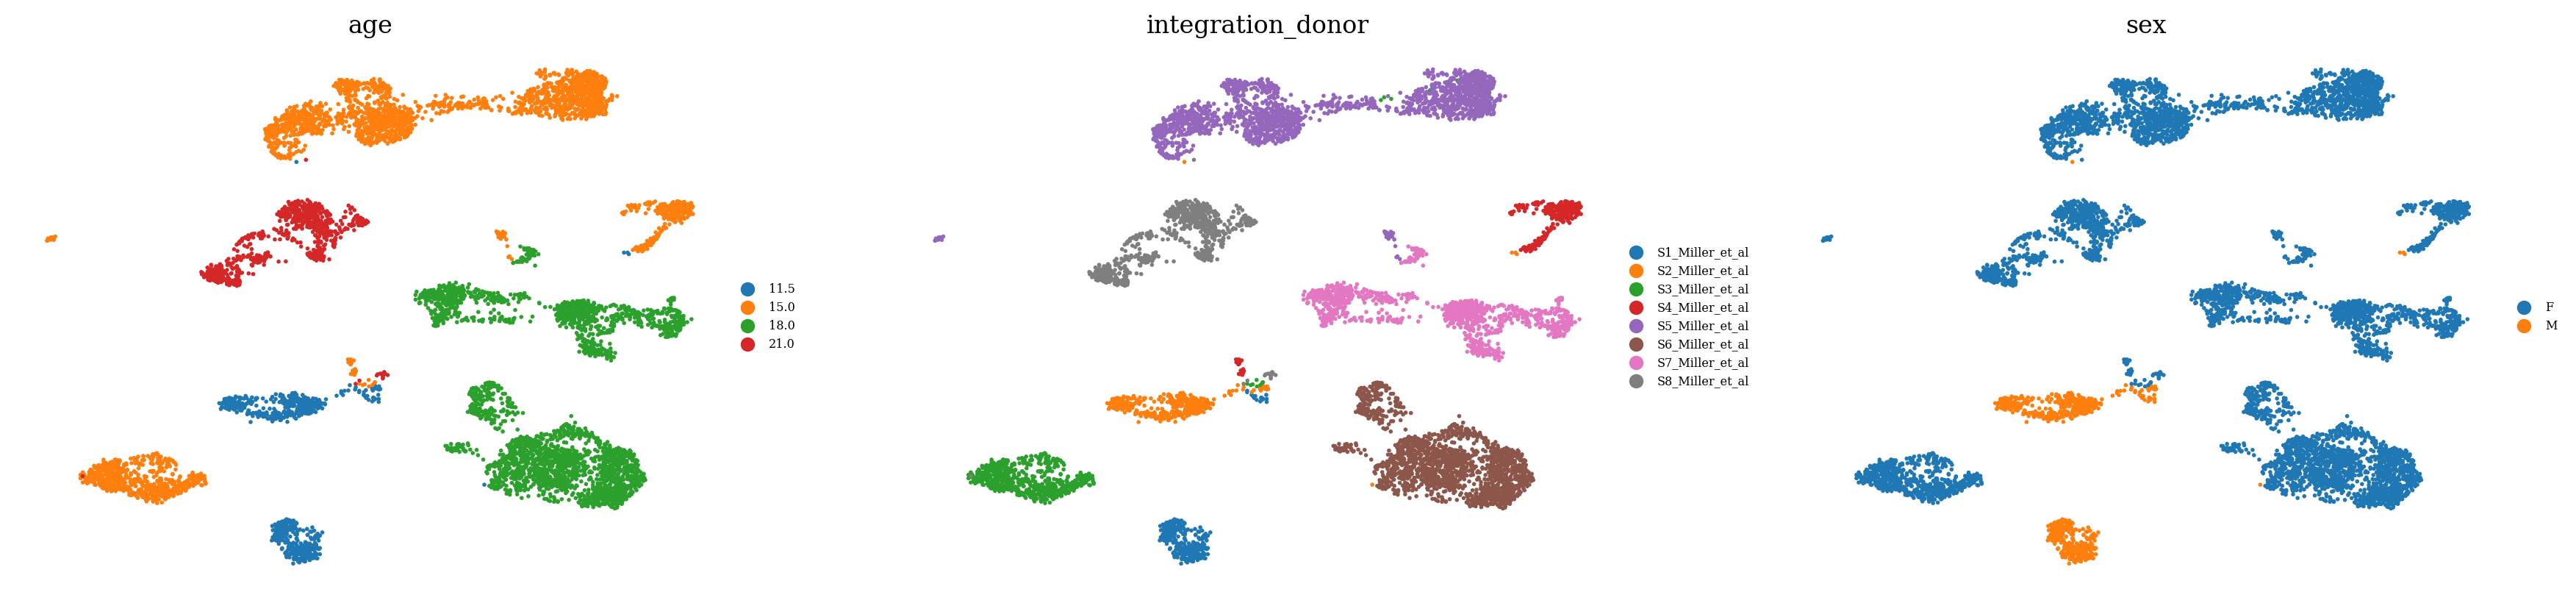

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

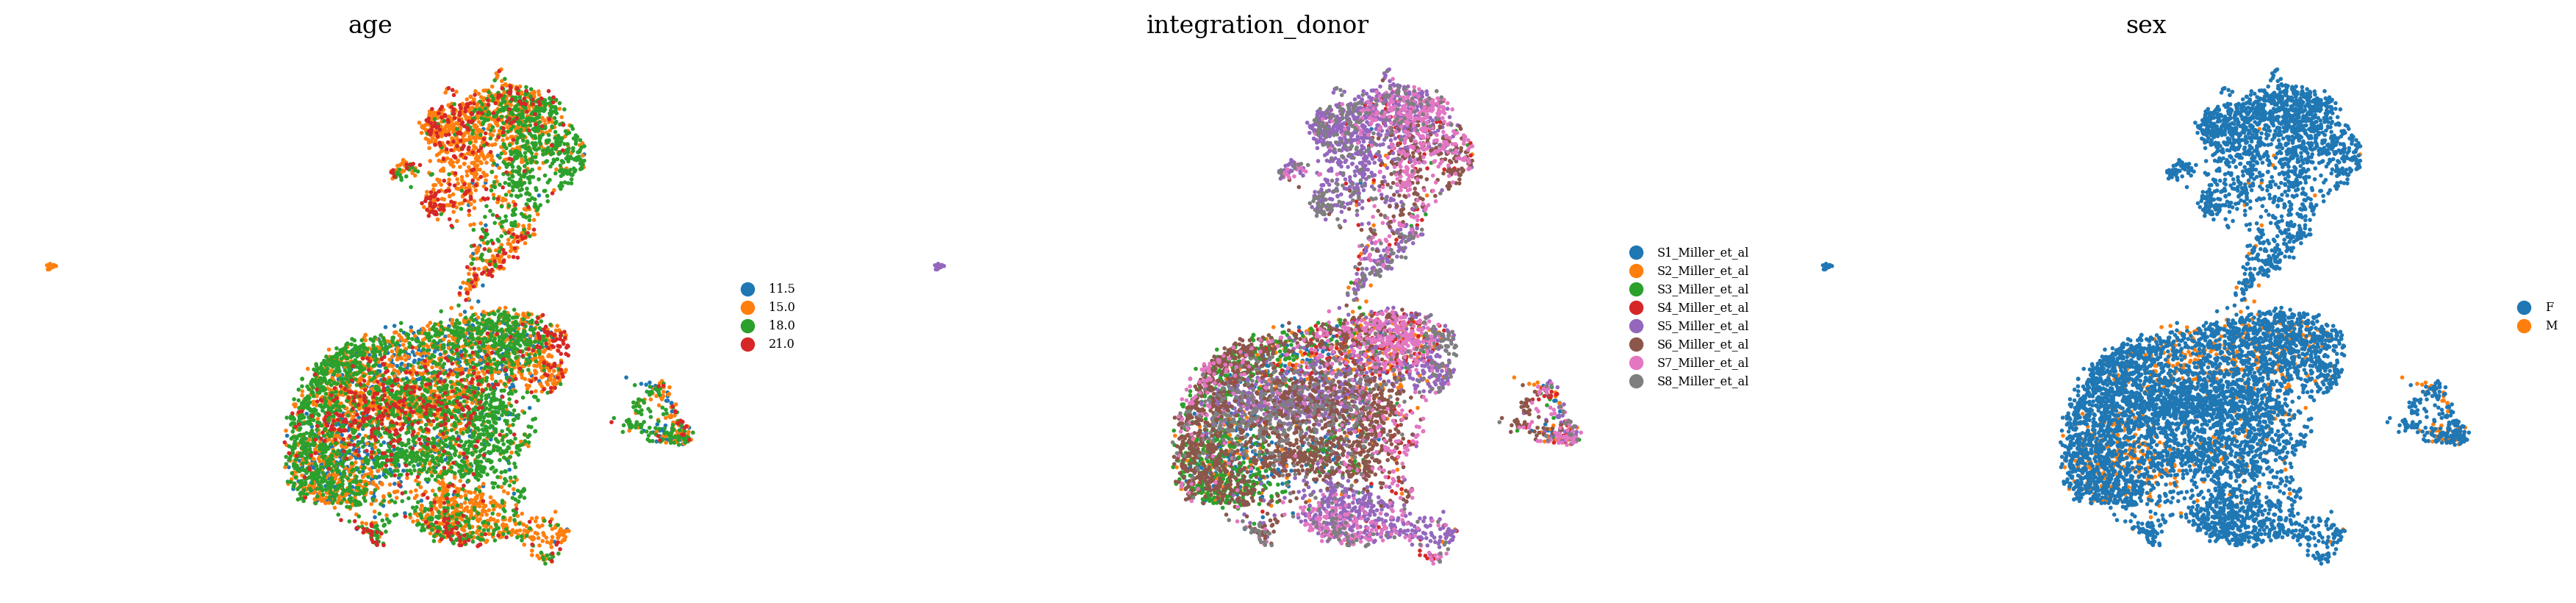

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  6%|▌         | 13/232 [00:00<00:01, 124.60it/s]

 13%|█▎        | 31/232 [00:00<00:01, 152.94it/s]

 20%|██        | 47/232 [00:00<00:01, 107.78it/s]

 25%|██▌       | 59/232 [00:00<00:01, 96.43it/s] 

 30%|███       | 70/232 [00:00<00:01, 90.70it/s]

 34%|███▍      | 80/232 [00:00<00:01, 87.26it/s]

 38%|███▊      | 89/232 [00:00<00:01, 85.03it/s]

 42%|████▏     | 98/232 [00:01<00:01, 83.41it/s]

 46%|████▌     | 107/232 [00:01<00:01, 82.26it/s]

 50%|█████     | 116/232 [00:01<00:01, 81.33it/s]

 54%|█████▍    | 125/232 [00:01<00:01, 80.83it/s]

 58%|█████▊    | 134/232 [00:01<00:01, 80.53it/s]

 62%|██████▏   | 143/232 [00:01<00:01, 80.34it/s]

 66%|██████▌   | 152/232 [00:01<00:00, 80.10it/s]

 69%|██████▉   | 161/232 [00:01<00:00, 80.02it/s]

 73%|███████▎  | 170/232 [00:01<00:00, 79.98it/s]

 77%|███████▋  | 179/232 [00:02<00:00, 78.45it/s]

 81%|████████  | 187/232 [00:02<00:00, 78.72it/s]

 84%|████████▍ | 195/232 [00:02<00:00, 78.92it/s]

 88%|████████▊ | 203/232 [00:02<00:00, 79.08it/s]

 91%|█████████ | 211/232 [00:02<00:00, 79.14it/s]

 94%|█████████▍| 219/232 [00:02<00:00, 78.85it/s]

 98%|█████████▊| 227/232 [00:02<00:00, 78.88it/s]

100%|██████████| 232/232 [00:02<00:00, 84.75it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.6204232659974825

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)